This notebook contains the essentials for automated and manual promoter annotation

# Import Packages

In [1]:
# built-in packages
from collections import Counter
from pathlib import Path
import re
import sys

# third-party packages
from Bio.SeqUtils import GC
from Bio.SeqUtils.MeltingTemp import Tm_NN
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, median_abs_deviation, pearsonr
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold, train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# import local bitome2
sys.path.append('../../bitome2')

from bitome.core import Bitome
from bitome.util import score_motif_match

# Load MG1655 Bitome

In [11]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [12]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [13]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Load PRECISE 1K

In [5]:
p1k = load_json_model('../data/p1k/precise1k.json.gz')
p1k_log_tpm = pd.read_csv('../data/p1k/log_tpm_qc_w_short_low_fpkm.csv', index_col=0)
p1k_gene_table = pd.read_csv('../data/p1k/gene_info.csv', index_col=0)
p1k_gene_table = p1k_gene_table.loc[p1k_log_tpm.index]
p1k_m_binarized = p1k.M_binarized.copy()
regulatory_ims = p1k.imodulon_table[p1k.imodulon_table['enrichment_category'] == 'Regulatory'].index
regulatory_m_binarized = p1k_m_binarized[regulatory_ims]

# create a copy of the log_tpm table that has entries removed for genes that are explicitly KO'ed
log_tpm_no_ko = p1k_log_tpm.copy().loc[p1k_gene_table.index]

for p1k_id, strain_desc in p1k.sample_table['Strain Description'].items():
    kos = [sub_str.split('del_')[1] for sub_str in strain_desc.split(' ') if 'del_' in sub_str]
    ko_idx = set(p1k_gene_table[p1k_gene_table['gene_name'].isin(kos)].index).intersection(set(log_tpm_no_ko.index))
    log_tpm_no_ko.loc[list(ko_idx), p1k_id] = None
    
# also need to account for the minicoli deletions
minicoli_p1k_ids = p1k.sample_table[p1k.sample_table['Strain Description'].str.contains('DGF')].index
minicoli_gene_kos = p1k_gene_table[p1k_gene_table['DGF_strain'] == False].index
log_tpm_no_ko.loc[minicoli_gene_kos, minicoli_p1k_ids] = None

# also remove the overexpressions of MalE
log_tpm_no_ko.loc['b4034', ['p1k_00666', 'p1k_00667']] = None

assert all(p1k_gene_table.index == log_tpm_no_ko.index)
assert all(p1k_gene_table.index == p1k_log_tpm.index)

# add some columns to gene table with summary stats - have to be cautious that we have 
p1k_gene_table = p1k_gene_table.assign(
    median_log_tpm=log_tpm_no_ko.median(axis=1),
    # this function doesn't nicely drop NAs automatically like the native DataFrame methods
    mad_log_tpm=log_tpm_no_ko.apply(lambda row: median_abs_deviation(row.dropna()), axis=1),
    pct10_log_tpm=log_tpm_no_ko.apply(lambda row: np.percentile(row, 10), axis=1),
    pct25_log_tpm=log_tpm_no_ko.apply(lambda row: np.percentile(row, 25), axis=1),
    max_log_tpm=log_tpm_no_ko.max(axis=1),
    min_log_tpm=log_tpm_no_ko.min(axis=1),
    mean_log_tpm=log_tpm_no_ko.mean(axis=1),
    skew=log_tpm_no_ko.skew(axis=1)
)

# add in our LOW cutoff
median_cutoff = 2

# compute inducibility metrics
p1k_gene_table = p1k_gene_table.assign(
    range_log_tpm=(p1k_gene_table['max_log_tpm'] - p1k_gene_table['min_log_tpm']),
    max_to_median=(p1k_gene_table['max_log_tpm'] - p1k_gene_table['median_log_tpm']),
    min_to_median=(p1k_gene_table['min_log_tpm'] - p1k_gene_table['median_log_tpm']),
    low=p1k_gene_table.apply(lambda row: row['median_log_tpm'] < median_cutoff, axis=1)
)

# determine complexes; do this crudely based on same TU/same gene prefix
def in_complex(bnum):
    co_tu_genes = []
    for tu in mg1655._gene_to_tus[bnum]:
        co_tu_genes.extend(mg1655._tu_to_genes[tu])
    co_tu_gene_names = [p1k_gene_table.loc[bn, 'gene_name'] for bn in co_tu_genes if bn in p1k_gene_table.index]
    complex_prefixes = [k for k, v in Counter([name[:3] for name in co_tu_gene_names]).items() if v > 1]
    return p1k_gene_table.loc[bnum, 'gene_name'][:3] in complex_prefixes
p1k_gene_table = p1k_gene_table.assign(
    in_complex=pd.Series(p1k_gene_table.index).apply(in_complex).values
)
p1k_gene_table = p1k_gene_table.rename(columns={'start': 'left', 'end': 'right'})

In [78]:
# useful to have a lookup of the bnumbers for the regulators of a given iM (where applicable)
reg_im_df = p1k.imodulon_table[p1k.imodulon_table['regulator'].notna()]

reg_exceptions = {
    'ppGpp': None,
    'RcsAB': 'rcsA;rcsB',
    'Thiamine diphosphate': None,
    'IHF': 'ihfA;ihfB',
    'FlhDC': 'flhD;flhC',
    'Leu-tRNA': None,
    'L-tryptophan': None,
    'Trp-tRNA': None,
    'H-NS': 'hns',
    'PlaR': 'yiaJ',
    'Val-tRNA': None,
    'GlaR': 'csiR',
    'Ile-tRNA': None,
    'His-tRNA': None,
    'UTP': None,
    'PyrR': 'ypdB',
    'CsqR': 'yihW',
    'SdhX': None,
    'NtrC': 'glnG',
    'ryhB': None,
    'dsrA': None,
    'gcvB': None
}
def reg_to_bnum(reg):
    if reg in reg_exceptions:
        gene_name_raw = reg_exceptions[reg]
    else:
        gene_name_raw = reg[0].lower() + reg[1:]
    if gene_name_raw is not None:
        # some cases where the regulator is a complex; have to handle
        gene_names = gene_name_raw.split(';')
        bnums = []
        for gene_name in gene_names:
            gene_row = p1k_gene_table[p1k_gene_table['gene_name'] == gene_name]
            # temp to catch issues
            assert not gene_row.empty, gene_name
            bnums.append(gene_row.index[0])
        return ';'.join(bnums)
    else:
        return None

unique_regs = list(set([reg for reg_str in test['regulator'] for reg in re.split(r'\+|/', reg_str)]))

reg_to_bnum_dict = {reg: reg_to_bnum(reg) for reg in unique_regs}

def reg_im_to_bnums(reg_im):
    reg_im_row = reg_im_df.loc[reg_im]
    reg_str = reg_im_row['regulator']
    bnums = filter(
        lambda x: x is not None,
        [reg_to_bnum_dict[reg]x for reg in re.split('r\+|/', reg_str)]
    )

reg_im_to_bnums = {reg_im: reg_im_to_bnums(reg_im) for reg_im in reg_im_df.index}

KeyError: 'RpoS+ppGpp+IHF+H-NS'

# RegulonDB Parsing

## File Parsing Helpers

In [6]:
REGULONDB_PATH = Path('../data/bitome2/mg1655/regulondb11.1/')

In [7]:
def read_regulon_db_file(filename) -> pd.DataFrame:
    """
    Given a filename for a raw TXT file from RegulonDB, parses into a DataFrame
    :param Union[str, Path] filename: the filename of the RegulonDB TXT file to read into a pandas DataFrame
    :return pd.DataFrame regulon_df: a pandas DataFrame parsed from a RegulonDB raw TXT file
    """

    full_filename = Path(REGULONDB_PATH, filename)

    with open(full_filename, 'r') as f:
        lines = f.readlines()

    comment = True
    i = 0
    while comment:
        if lines[i].startswith('#') or lines[i].startswith(' #'):
            i += 1
        else:
            comment = False

    names = [line[5:-1].strip() for line in lines if re.match(r'# \d', line)]
    df = pd.read_csv(full_filename, index_col=None, skiprows=i, sep='\t', header=None, names=names)

    return df.drop_duplicates()

## RegulonDB Loading

In [15]:
promoter_df = read_regulon_db_file('promoter.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

reg_phrase_df = read_regulon_db_file('reg_phrase.txt')
reg_phrase_df = reg_phrase_df.dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

reg_phrase_ri_link_df = read_regulon_db_file('reg_phrase_ri_link.txt')

ri_df = read_regulon_db_file('regulatory_interaction.txt')
ri_df = ri_df.dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

ri_df = ri_df.merge(reg_phrase_ri_link_df, on='REGULATORY_INTERACTION_ID', how='left')
ri_df = ri_df.merge(reg_phrase_df, on='REG_PHRASE_ID', how='left')
ri_df = ri_df.merge(promoter_df, on='PROMOTER_ID', how='left')
# there's a weird row with <br> reg interaction ID that has no other info, very bizarre
ri_df = ri_df.dropna(subset='PHRASE')

# add a column to more closely define the "bins" the TFBS are in
# (per https://journals.asm.org/doi/epub/10.1128/MMBR.00037-08)
def pos_to_bin(pos):
    if pd.notna(pos):
        if pos < -35:
            return 'upstream'
        elif pos >= -35 and pos <= 0:
            return 'core'
        else:
            return 'downstream'
    else:
        return None
ri_df = ri_df.assign(
    site_bin=ri_df['CENTER_POSITION'].apply(pos_to_bin)
)

# get in the regulon information
regulon_prom_link = read_regulon_db_file('regulonfuncpromoter_link_tmp.txt')
ri_df = ri_df.merge(regulon_prom_link, on='PROMOTER_ID', how='left')

regulon_name_df = read_regulon_db_file('regulon_tmp.txt').drop(columns=['KEY_ID_ORG'])
regulon_function_df = read_regulon_db_file('regulon_function_tmp.txt').drop(columns=['KEY_ID_ORG'])
regulon_df = regulon_function_df.merge(regulon_name_df, how='left', on='REGULON_ID')
ri_df = ri_df.merge(regulon_df, on='REGULON_FUNCTION_ID', how='left')
ri_df.head()

conformation_df = read_regulon_db_file('conformation.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])
effector_df = read_regulon_db_file('effector.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])
conf_effector_link_df = read_regulon_db_file('conformation_effector_link.txt')

# turns out there can be multiple effectors per conformation; collapse these cases to preserve conformation ID uniqueness
conf_effector_df = conformation_df.merge(conf_effector_link_df, on='CONFORMATION_ID', how='left')
conf_effector_df = conf_effector_df.merge(effector_df, how='left', on='EFFECTOR_ID')
dup_conf_ids = [conf_id for conf_id, conf_df in conf_effector_df.groupby('CONFORMATION_ID') if conf_df.shape[0] > 1]
effector_cols_to_join = ['EFFECTOR_ID', 'EFFECTOR_NAME', 'EFFECTOR_TYPE', 'EFFECTOR_NOTE', 'EFFECTOR_NOTE_WEB']
def join_effector_rows(eff_df):
    new_row = {}
    for col in effector_cols_to_join:
        if pd.isna(eff_df[col]).all():
            new_row[col] = np.nan
        else:
            new_row[col] = ';'.join(eff_df[col].fillna(value='None'))
    remaining_row = eff_df.drop(columns=effector_cols_to_join).iloc[0]
    final_row = dict(remaining_row) | new_row
    return final_row
comb_effector_rows = [join_effector_rows(conf_effector_df[conf_effector_df['CONFORMATION_ID'] == dup_conf_id]) for dup_conf_id in dup_conf_ids]
# remove the previous duplicate rows and add our combined ones
drop_idx = conf_effector_df[conf_effector_df['CONFORMATION_ID'].isin(dup_conf_ids)].index
conf_effector_df = conf_effector_df.drop(index=drop_idx)
conf_effector_df = pd.concat([
    conf_effector_df,
    pd.DataFrame(comb_effector_rows, index=range(max(conf_effector_df.index)+1, max(conf_effector_df.index)+1+len(comb_effector_rows)))
])

# combine the conformation with regulatory interaction ID
ri_df = ri_df.merge(conf_effector_df, how='left', on='CONFORMATION_ID')

# add in the TFBS site information
site_df = read_regulon_db_file('site.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])
ri_df = ri_df.merge(site_df, how='left', on='SITE_ID')

# add in transcription factor information
tf_df = read_regulon_db_file('t_factor_d_tmp.txt')
ri_df = ri_df.merge(tf_df, how='left', left_on='TRANSCRIPTION_FACTOR_ID', right_on='T_FACTOR_ID')

# separately load the TU/promoter DF - don't want to combine TUs into single reg interaction rows at the moment
# but only want TUs that have promoters
tu_df = read_regulon_db_file('transcription_unit.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])
tu_df = tu_df[tu_df['PROMOTER_ID'].notna()]

# TSS Annotation [Auto]

We want to annotate each promoter region - start with TSS as our anchor points

Gather all annotated information we can about each TSS

## TU, Genes, RegulonDB, PRECISE-1K, -10/-35

In [36]:
with_tss.head()

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,TRANSCRIPTION_UNIT_ID,PROMOTER_ID,TRANSCRIPTION_UNIT_NAME
0,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0,ECK120008913,ECK120009851,astCADBE
1,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0,ECK120008914,ECK120009852,astCADBE
2,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0,ECK120008915,ECK120009853,astCADBE
3,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0,ECK120008916,ECK120009855,nrdHIEF
4,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0,ECK120008917,ECK120010879,cpxPQ


In [37]:
with_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()]
# merge in the RegulonDB TSS info; this gives us the promoter ID, which gives us all the regulatory interaction stuff
# PROMOTER_ID is unique per TSS, EXCEPT for the glmY case with different sigma factor promoters from same TSS
with_tss = with_tss.merge(tu_df, how='left', left_index=True, right_on='TRANSCRIPTION_UNIT_ID')
with_tss = with_tss.drop(columns=['OPERON_ID', 'TRANSCRIPTION_UNIT_NOTE', 'TRANSCRIPTION_UNIT_NOTE_WEB'])
with_tss = with_tss.set_index('TRANSCRIPTION_UNIT_ID')

tss_recon_rows = []
tss_loc_to_count = {}
for tu_id, tu_row in with_tss.iterrows():
    
    tss_recon_row = {}

    # TSS location, strand, and generate new ID with these info
    tss_loc = int(tu_row['tss'])
    tss_strand = int(tu_row['strand'])
    def strand_to_symbol(strand_int):
        if strand_int == 1:
            return 'f'
        else:
            return 'r'
    tss_recon_row['tss'] = tss_loc
    tss_recon_row['strand'] = tss_strand
    tss_recon_row['tss_base'] = str(mg1655.get_sequence(tss_loc, tss_loc, tss_strand))
    if tss_loc in tss_loc_to_count:
        tss_loc_to_count[tss_loc] += 1
        tss_recon_id = f"TSS_{tss_loc}_{strand_to_symbol(tss_strand)}_{tss_loc_to_count[tss_loc]}"
    else:
        tss_loc_to_count[tss_loc] = 1
        tss_recon_id = f"TSS_{tss_loc}_{strand_to_symbol(tss_strand)}"
    tss_recon_row['tss_recon_id'] = tss_recon_id
    rdb_prom_id = tu_row['PROMOTER_ID']
    tss_recon_row['promoter_id'] = rdb_prom_id

    # TU and genes controlled by TSS
    genes_controlled = sorted(mg1655._tu_to_genes[tu_id])
    tss_recon_row['tu_id'] = tu_id
    tss_recon_row['tu_name'] = tu_row['name']
    tss_recon_row['gene_ids'] = ';'.join(genes_controlled) if genes_controlled else None
    tss_recon_row['gene_names'] = ';'.join(list(mg1655.gene_table.loc[genes_controlled]['name'])) \
                                    if genes_controlled else None
    tss_recon_row['n_genes'] = len(genes_controlled)
    
    # properties of TUs
    tss_recon_row['tu_left'] = tu_row['left']
    tss_recon_row['tu_right'] = tu_row['right']
    # because 1-indexing have to add that one back, right and left are inclusive
    tss_recon_row['tu_len'] = int(tu_row['right'] - tu_row['left'] + 1)
    tss_recon_row['tu_gc'] = GC(mg1655.get_sequence(tu_row['left'], tu_row['right'], tss_strand)) / 100

    # get gene expression information
    genes_with_expression = sorted(list(set(genes_controlled).intersection(set(p1k_gene_table.index))))
    if genes_with_expression:
        tss_recon_row['genes_with_log_tpm'] = ';'.join(genes_with_expression)
        tss_recon_row['median_of_log_tpm_medians'] = np.median(
            p1k_gene_table.loc[genes_with_expression]['median_log_tpm']
        )
        tss_recon_row['mad_of_log_tpm_medians'] = median_abs_deviation(
            p1k_gene_table.loc[genes_with_expression]['median_log_tpm']
        )
        tss_recon_row['max_log_tpm'] = max(p1k_gene_table.loc[genes_with_expression]['max_log_tpm'])
        tss_recon_row['min_log_tpm'] = min(p1k_gene_table.loc[genes_with_expression]['min_log_tpm'])
        
    # get iModulons that contain any of these genes; also just regulatory imodulons
    genes_in_p1k = list(set(genes_controlled).intersection(set(p1k_m_binarized.index)))
    gene_m_binar_rows = p1k_m_binarized.loc[genes_in_p1k]
    gene_in_im_idxes, im_with_gene_idxes = np.where(gene_m_binar_rows == 1)
    genes_in_im = sorted(list(set(np.array(genes_in_p1k)[gene_in_im_idxes])))
    ims = sorted(list(set(np.array(p1k_m_binarized.columns)[im_with_gene_idxes])))
    tss_recon_row['imodulons'] = ';'.join(ims) if ims else None
    tss_recon_row['genes_in_im'] = ';'.join(genes_in_im) if genes_in_im else None
    tss_recon_row['n_genes_in_im'] = len(genes_in_im) if genes_in_im else 0
    tss_recon_row['frac_genes_in_im'] = len(genes_in_im) / len(genes_controlled) if genes_controlled else None
    
    gene_m_binar_reg_rows = regulatory_m_binarized.loc[genes_in_p1k]
    gene_in_reg_im_idxes, reg_im_with_gene_idxes = np.where(gene_m_binar_reg_rows == 1)
    genes_in_reg_im = sorted(list(set(np.array(genes_in_p1k)[gene_in_reg_im_idxes])))
    reg_ims = sorted(list(set(np.array(regulatory_m_binarized.columns)[reg_im_with_gene_idxes])))
    tss_recon_row['regulatory_imodulons'] = ';'.join(reg_ims) if reg_ims else None
    tss_recon_row['genes_in_reg_im'] = ';'.join(genes_in_reg_im) if genes_in_reg_im else None
    tss_recon_row['n_genes_in_reg_im'] = len(genes_in_reg_im) if genes_in_reg_im else 0
    tss_recon_row['frac_genes_in_reg_im'] = len(genes_in_reg_im) / len(genes_controlled) if genes_controlled else None

    box_row = tu_row[
        ['sigma_factor', 'box_10_left', 'box_10_right', 'box_35_left', 'box_35_right']
    ]
    # add the box information to the existing dictionary
    tss_recon_row = tss_recon_row | dict(box_row)
    
    # add in regulon information from RegulonDB
    reg_int_for_prom_df = ri_df[ri_df['PROMOTER_ID'] == rdb_prom_id]
    # too complex to encode all TFBS information in one row - but indicate generally if this TSS has any or not
    tss_recon_row['has_tfbs'] = not reg_int_for_prom_df.empty
    regulons = sorted(list(set([
        reg for reg_combo_str in reg_int_for_prom_df['REGULON_NAME']
        if pd.notna(reg_combo_str) for reg in reg_combo_str.split(',')
    ])))
    tss_recon_row['regulons'] = ';'.join(regulons) if regulons else None

    tss_recon_rows.append(tss_recon_row)
    
tss_recon_df = pd.DataFrame(tss_recon_rows)
tss_recon_df = tss_recon_df.set_index('tss_recon_id')
tss_recon_df.head()

,tss,strand,tss_base,promoter_id,tu_id,tu_name,gene_ids,gene_names,n_genes,tu_left,...,genes_in_reg_im,n_genes_in_reg_im,frac_genes_in_reg_im,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,has_tfbs,regulons
tss_recon_id,,,,,,,,,,,,,,,,,,,,,
TSS_1832013_r,1832013,-1,A,ECK120009851,ECK120008913,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,b1744;b1745;b1746;b1747;b1748,5,1.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,False,None
TSS_1832044_r,1832044,-1,A,ECK120009852,ECK120008914,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,b1744;b1745;b1746;b1747;b1748,5,1.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,True,ArgR;NtrC
TSS_1832039_r,1832039,-1,G,ECK120009853,ECK120008915,astCADBE,b1744;b1745;b1746;b1747;b1748,astE;astB;astD;astA;astC,5,1825955.0,...,b1744;b1745;b1746;b1747;b1748,5,1.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,False,None
TSS_2800656_f,2800656,1,A,ECK120009855,ECK120008916,nrdHIEF,b2673;b2674;b2675;b2676,nrdH;nrdI;nrdE;nrdF,4,2800656.0,...,b2673;b2674;b2675;b2676,4,1.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,True,Fur;IscR;NrdR
TSS_4105785_f,4105785,1,G,ECK120010879,ECK120008917,cpxPQ,b4484,cpxP,1,4105785.0,...,b4484,1,1.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,True,CpxR


## Transcriptional Interference

Upstream/downstream/converging calculations to reflect: https://pubmed.ncbi.nlm.nih.gov/15922833/#&gid=article-figures&pid=figure-1-uid-0

In [39]:
tss_add_row_dicts = []

DIVERGENT_RANGE = 200

converging_tss_pairs = []
tandem_tss_pairs = []
diverging_tss_pairs = []
alternate_tss_pairs = []

for tss_recon_id, tss_recon_row in tss_recon_df.iterrows():
    
    tss_row_add_dict = {}
    
    current_strand = tss_recon_row['strand']
    current_tss = tss_recon_row['tss']
    current_tu_left, current_tu_right = tss_recon_row['tu_left'], tss_recon_row['tu_right']
    
    # get any TSS that are within this particular TU
    tss_within_tu_df = tss_recon_df[(tss_recon_df['tss'] > current_tu_left) & (tss_recon_df['tss'] < current_tu_right)]
    
    if not tss_within_tu_df.empty:
        for tss_within_id, tss_within_ru_row in tss_within_tu_df.iterrows():
            if tss_within_ru_row['strand'] == current_strand:
                tandem_tss_pairs.append((tss_recon_id, tss_within_id))
                # if tandem TSSes handle exactly the same genes, they are alternates
                # this depends on these gene_ids entries being sorted
                if tss_recon_row['gene_ids'] == tss_within_ru_row['gene_ids']:
                    alternate_tss_pairs.append((tss_recon_id, tss_within_id))
            else:
                converging_tss_pairs.append((tss_recon_id, tss_within_id))
                
    # now look for likely overlapping (divergent) promoters; 
    if current_strand == 1:
        divergent_tss_df = tss_recon_df[
            (tss_recon_df['tss'] < current_tss) & (tss_recon_df['tss'] > (current_tss - DIVERGENT_RANGE))
            & (tss_recon_df['strand'] != current_strand)
        ]
    else:
        divergent_tss_df = tss_recon_df[
            (tss_recon_df['tss'] > current_tss) & (tss_recon_df['tss'] < (current_tss + DIVERGENT_RANGE))
            & (tss_recon_df['strand'] != current_strand)
        ]
    # does nothing if divergent_tss_df is empty, which is fine
    diverging_tss_pairs.extend([(tss_recon_id, div_id) for div_id in divergent_tss_df.index])
        
# convert the pairs to unique pairs
converging_tss_pairs = list(set([tuple(sorted(pair)) for pair in converging_tss_pairs]))
tandem_tss_pairs = list(set([tuple(sorted(pair)) for pair in tandem_tss_pairs]))
diverging_tss_pairs = list(set([tuple(sorted(pair)) for pair in diverging_tss_pairs]))
alternate_tss_pairs = list(set([tuple(sorted(pair)) for pair in alternate_tss_pairs]))

# create lookups that relate each tss to its relevant pairs
tss_to_convergent = {}
for conv_tss_1, conv_tss_2 in converging_tss_pairs:
    if conv_tss_1 in tss_to_convergent:
        tss_to_convergent[conv_tss_1].append(conv_tss_2)
    else:
        tss_to_convergent[conv_tss_1] = [conv_tss_2]
    if conv_tss_2 in tss_to_convergent:
        tss_to_convergent[conv_tss_2].append(conv_tss_1)
    else:
        tss_to_convergent[conv_tss_2] = [conv_tss_1]
tss_to_convergent = {k: sorted(v) for k, v in tss_to_convergent.items()}

tss_to_tandem = {}
for tand_tss_1, tand_tss_2 in tandem_tss_pairs:
    if tand_tss_1 in tss_to_tandem:
        tss_to_tandem[tand_tss_1].append(tand_tss_2)
    else:
        tss_to_tandem[tand_tss_1] = [tand_tss_2]
    if tand_tss_2 in tss_to_tandem:
        tss_to_tandem[tand_tss_2].append(tand_tss_1)
    else:
        tss_to_tandem[tand_tss_2] = [tand_tss_1]
tss_to_tandem = {k: sorted(v) for k, v in tss_to_tandem.items()}

tss_to_diverging = {}
for div_tss_1, div_tss_2 in diverging_tss_pairs:
    if div_tss_1 in tss_to_diverging:
        tss_to_diverging[div_tss_1].append(div_tss_2)
    else:
        tss_to_diverging[div_tss_1] = [div_tss_2]
    if div_tss_2 in tss_to_diverging:
        tss_to_diverging[div_tss_2].append(div_tss_1)
    else:
        tss_to_diverging[div_tss_2] = [div_tss_1]
tss_to_diverging = {k: sorted(v) for k, v in tss_to_diverging.items()}
        
tss_to_alternate = {}
for alt_tss_1, alt_tss_2 in alternate_tss_pairs:
    if alt_tss_1 in tss_to_alternate:
        tss_to_alternate[alt_tss_1].append(alt_tss_2)
    else:
        tss_to_alternate[alt_tss_1] = [alt_tss_2]
    if alt_tss_2 in tss_to_alternate:
        tss_to_alternate[alt_tss_2].append(alt_tss_1)
    else:
        tss_to_alternate[alt_tss_2] = [alt_tss_1]
tss_to_alternate = {k: sorted(v) for k, v in tss_to_alternate.items()}
        
interference_rows = []
for tss_recon_id, tss_recon_row in tss_recon_df.iterrows():
    interference_row = {}
    interference_row['convergent_tss_ids'] = ';'.join(tss_to_convergent[tss_recon_id]) if tss_recon_id in tss_to_convergent else None
    interference_row['tandem_tss_ids'] = ';'.join(tss_to_tandem[tss_recon_id]) if tss_recon_id in tss_to_tandem else None
    interference_row['diverging_tss_ids'] = ';'.join(tss_to_diverging[tss_recon_id]) if tss_recon_id in tss_to_diverging else None
    interference_row['alternate_tss_ids'] = ';'.join(tss_to_alternate[tss_recon_id]) if tss_recon_id in tss_to_alternate else None
    interference_rows.append(interference_row)
interference_df = pd.DataFrame(interference_rows, index=tss_recon_df.index)

tss_recon_df = pd.concat([tss_recon_df, interference_df], axis=1)
tss_recon_df = tss_recon_df.assign(
    has_convergence=tss_recon_df['convergent_tss_ids'].notna(),
    has_tandem=tss_recon_df['tandem_tss_ids'].notna(),
    has_diverging=tss_recon_df['diverging_tss_ids'].notna(),
    has_alternate=tss_recon_df['alternate_tss_ids'].notna(),
    has_interference=tss_recon_df[['convergent_tss_ids', 'tandem_tss_ids', 'diverging_tss_ids']].notna().any(axis=1)
)

## Core Promoter Sequences

Add -10 and -35 box sequences, and TSS base, as features

In [40]:
all_sigma_motifs = mg1655.create_sigma_motifs()

/Users/cam/Projects/Strainware-s/workflows_CAD/promoter_survey/../../bitome2/bitome/util.py:175: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_len, _ = mode(sequence_lens)


In [42]:
tss_core_prom_seq_row_dicts = []

# define transcription bubble params
BUBBLE_UP = 10
BUBBLE_DOWN = 2

for tss_recon_id, tss_recon_row in tss_recon_df.iterrows():
    
    tss_prom_seq_dict = {}

    b10_l, b10_r = tss_recon_row['box_10_left'], tss_recon_row['box_10_right']
    b35_l, b35_r = tss_recon_row['box_35_left'], tss_recon_row['box_35_right']
    strand = tss_recon_row['strand']
    
    # melting temperature of CRE; transcription bubble is from -10 to +2
    if strand == 1:
        melt_left, melt_right = tss_recon_row['tss'] - BUBBLE_UP, tss_recon_row['tss'] + BUBBLE_DOWN
    else:
        melt_left, melt_right = tss_recon_row['tss'] - BUBBLE_DOWN, tss_recon_row['tss'] + BUBBLE_UP
    tss_tm = Tm_NN(mg1655.get_sequence(melt_left, melt_right, strand))
    tss_prom_seq_dict['tss_tm'] = tss_tm

    # -10/-35 box sequences and motif scores
    if all([pd.notna(b) for b in [b10_l, b10_r, b35_l, b35_r]]):

        b10_seq = str(mg1655.get_sequence(b10_l, b10_r, strand))
        b35_seq = str(mg1655.get_sequence(b35_l, b35_r, strand))
        
        for sig, sig_motif_dict in all_sigma_motifs.items():
            box_10_pssm = sig_motif_dict['-10'].pssm
            box_35_pssm = sig_motif_dict['-35'].pssm
            if len(box_10_pssm['A']) == len(b10_seq):
                b10_score = score_motif_match(b10_seq, box_10_pssm)
                tss_prom_seq_dict[f'{sig}_box_10_score'] = b10_score
            else:
                tss_prom_seq_dict[f'{sig}_box_10_score'] = None
            if len(box_35_pssm['A']) == len(b35_seq):
                b35_score = score_motif_match(b35_seq, box_35_pssm)
                tss_prom_seq_dict[f'{sig}_box_35_score'] = b35_score
            else:
                tss_prom_seq_dict[f'{sig}_box_35_score'] = None

        # spacers
        if strand == 1:
            spacer_l, spacer_r = b35_r + 1, b10_l - 1
        else:
            spacer_l, spacer_r = b10_r + 1, b35_l - 1
        spacer_len = min(spacer_r - spacer_l + 1, 0)
        if spacer_len > 0:
            spacer_seq = mg1655.get_sequence(spacer_l, spacer_r, strand)
            spacer_gc = GC(spacer_seq) / 100
        else:
            spacer_seq = None
            spacer_gc = None

    else:
        b10_seq = None
        b35_seq = None
        spacer_len = None
        spacer_gc = None
        
    tss_prom_seq_dict['box_10_seq'] = b10_seq
    tss_prom_seq_dict['box_35_seq'] = b35_seq
    tss_prom_seq_dict['spacer_len'] = spacer_len
    tss_prom_seq_dict['spacer_gc'] = spacer_gc
    
    tss_core_prom_seq_row_dicts.append(tss_prom_seq_dict)
    
core_prom_df = pd.DataFrame(tss_core_prom_seq_row_dicts, index=tss_recon_df.index)

tss_recon_df = pd.concat([tss_recon_df, core_prom_df], axis=1)

## Genome Organization

In [43]:
def get_rep_region(row):
    new_row = pd.Series({'left': row['tss'], 'right': row['tss'], 'strand': row['strand']})
    return mg1655.replication_region(new_row)
tss_recon_df = tss_recon_df.assign(
    replication_region=tss_recon_df.apply(get_rep_region, axis=1)
)

In [48]:
tss_recon_df.to_csv('../data/promoter_survey/tss_recon.csv')

# TSS Annotation [Manual]

## View TSS Row

In [54]:
tss_idx_to_annotate = 1
tss_row = tss_recon_df.iloc[tss_idx_to_annotate, :]
tss_row

tss                                                1832044
strand                                                  -1
tss_base                                                 A
promoter_id                                   ECK120009852
tu_id                                         ECK120008914
tu_name                                           astCADBE
gene_ids                     b1744;b1745;b1746;b1747;b1748
gene_names                        astE;astB;astD;astA;astC
n_genes                                                  5
tu_left                                          1825955.0
tu_right                                         1832044.0
tu_len                                                6090
tu_gc                                             0.556322
genes_with_log_tpm           b1744;b1745;b1746;b1747;b1748
median_of_log_tpm_medians                         2.766048
mad_of_log_tpm_medians                            0.047074
max_log_tpm                                      10.1604

## TFBS/Regulatory Interaction Info

In [55]:
cols_of_interest = [
    'FINAL_STATE', 'T_FACTOR_NAME', 'RI_FUNCTION', 'CENTER_POSITION', 'SITE_LENGTH', 'site_bin', 'TYPE', 'PHRASE', 'REG_PHRASE_FUNCTION',
    'REGULON_FUNCTION_NAME', 'REGULON_NAME',
    'INTERACTION_TYPE', 'CONFORMATION_TYPE', 'APO_HOLO_CONFORMATION',
    'EFFECTOR_NAME', 'EFFECTOR_TYPE',
    'SITE_POSLEFT', 'SITE_POSRIGHT', 'SITE_SEQUENCE', 'SITE_LENGTH'
]

ri_df[ri_df['PROMOTER_ID'] == tss_row['promoter_id']][cols_of_interest]

,FINAL_STATE,T_FACTOR_NAME,RI_FUNCTION,CENTER_POSITION,SITE_LENGTH,site_bin,TYPE,PHRASE,REG_PHRASE_FUNCTION,REGULON_FUNCTION_NAME,REGULON_NAME,INTERACTION_TYPE,CONFORMATION_TYPE,APO_HOLO_CONFORMATION,EFFECTOR_NAME,EFFECTOR_TYPE,SITE_POSLEFT,SITE_POSRIGHT,SITE_SEQUENCE,SITE_LENGTH
1145,ArgR-L-arginine,ArgR,activator,-121.5,18.0,upstream,remote,"[ArgR,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Allosteric,Active,Holo,L-arginine,positive,1832157.0,1832174,gtgcatataaAGTGAATACGTTTGCGATgtgggtgaat,18.0
1146,ArgR-L-arginine,ArgR,activator,-99.5,18.0,upstream,remote,"[ArgR,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Allosteric,Active,Holo,L-arginine,positive,1832135.0,1832152,aaccaaaccaTATGCATTTAAAGTGCATataaagtgaa,18.0
1147,ArgR-L-arginine,ArgR,activator,-78.5,18.0,upstream,proximal,"[ArgR,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Allosteric,Active,Holo,L-arginine,positive,1832114.0,1832131,aactggaaatCAAGGAGTTATAACCAAAccatatgcat,18.0
1148,ArgR-L-arginine,ArgR,activator,-47.5,18.0,upstream,proximal,"[ArgR,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Allosteric,Active,Holo,L-arginine,positive,1832083.0,1832100,cagtgataaaAGTGCATAAACGGCGGAGgctaactgga,18.0
1149,NtrC-phosphorylated,NtrC,activator,-275.0,17.0,upstream,remote,"[NtrC,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Covalent,Active,Holo,Phosphate,positive,1832311.0,1832327,gggcatttttTGCGCCATCGTTGACATcattaacaac,17.0
1150,NtrC-phosphorylated,NtrC,activator,-253.0,17.0,upstream,remote,"[NtrC,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Covalent,Active,Holo,Phosphate,positive,1832289.0,1832305,tgacgcagcgCGCACCAAAAGCGGGCAttttttgcgc,17.0
1151,NtrC-phosphorylated,NtrC,activator,-233.0,17.0,upstream,remote,"[NtrC,+]",activator,ArgR activator NtrC activator,"ArgR,NtrC",Covalent,Active,Holo,Phosphate,positive,1832269.0,1832285,tggaaattacTGCGCCATTCTGACGCAgcgcgcacca,17.0


## iModulon Activity vs Gene Expressions

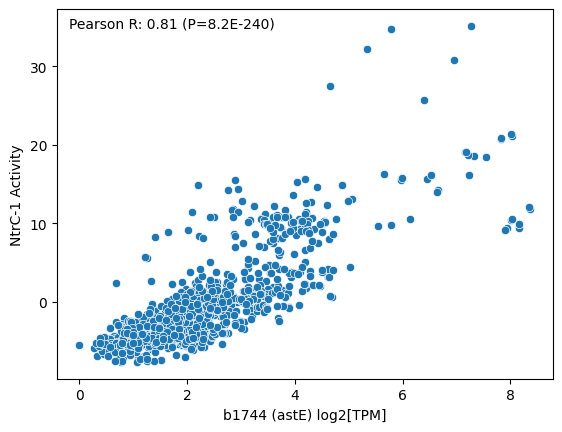

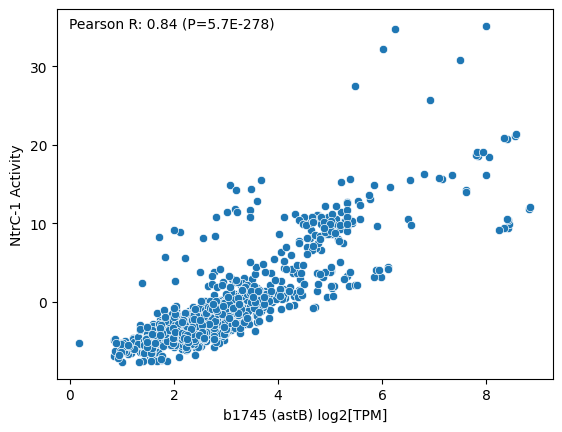

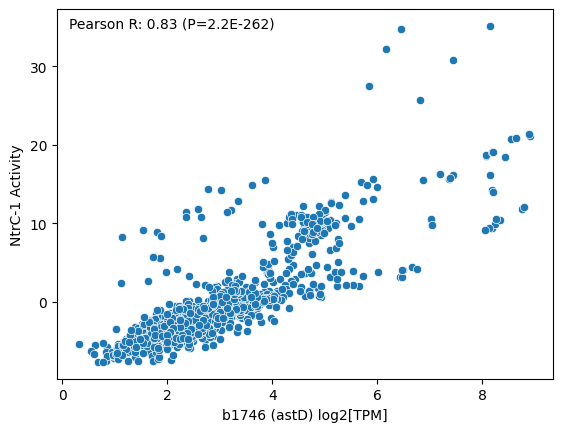

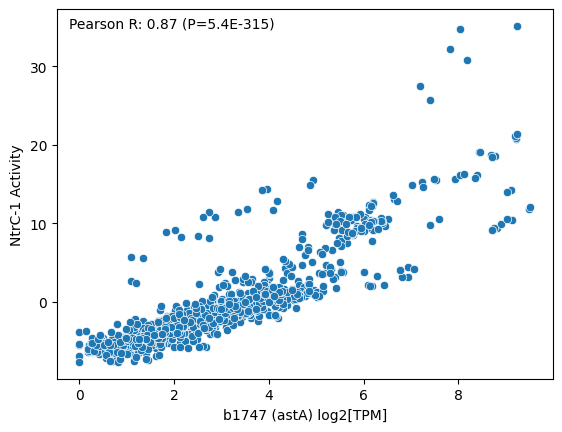

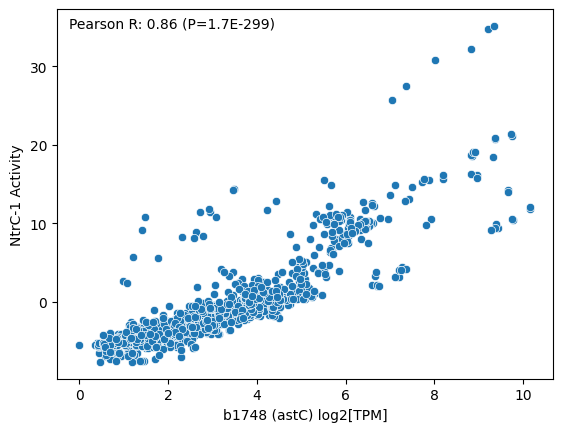

In [56]:
for reg_im in tss_row['regulatory_imodulons'].split(';'):
    
    for gene_id in tss_row['gene_ids'].split(';'):
        if gene_id in p1k_log_tpm.index:
            
            gene_log_tpm = p1k_log_tpm.loc[gene_id]
            im_act = p1k.A.loc[reg_im]
            
            r, p = pearsonr(gene_log_tpm, im_act)
            
            _, ax = plt.subplots()
            sns.scatterplot(x=p1k_log_tpm.loc[gene_id], y=p1k.A.loc[reg_im], ax=ax)
            ax.set_xlabel(f"{gene_id} ({p1k_gene_table.loc[gene_id]['gene_name']}) log2[TPM]")
            ax.set_ylabel(f'{reg_im} Activity')
            ax.text(0.025, 0.95, f'Pearson R: {r:.2f} (P={p:.1E})', transform=ax.transAxes)

# TSS Summary

## Unique Genes

In [57]:
unique_gids = list(set([gid for gids_raw in tss_recon_df['gene_ids'] if pd.notna(gids_raw) for gid in gids_raw.split(';')]))
len(unique_gids)

2631

## Locations on Genome

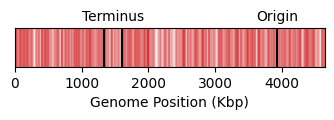

In [59]:
_, ax = plt.subplots(figsize=(4, 0.5))

scale_factor = 1000
poses_scaled = tss_recon_df['tss'].unique() / scale_factor

for scale_pos in poses_scaled:
    ax.axvline(scale_pos, color='tab:red', linewidth=0.1)

origin_mean = np.mean(mg1655.origin) / scale_factor
ax.axvline(origin_mean, color='black', linewidth=1.5)
ax.text(origin_mean, 0.12, 'Origin', ha='center')

ax.axvline(mg1655.terminus[0] / scale_factor, color='black', linewidth=1.5)
ax.axvline(mg1655.terminus[1] / scale_factor, color='black', linewidth=1.5)
ax.text(np.mean(mg1655.terminus) /scale_factor, 0.12, 'Terminus', ha='center')

ax.set_xlim(0, mg1655.seq_length / scale_factor)
ax.set_ylim(0, 0.1)
ax.set_yticks([])
ax.set_xlabel('Genome Position (Kbp)')

plt.savefig('/Users/cam/Downloads/tss_locs.png', dpi=400, bbox_inches='tight')

## Replication Region

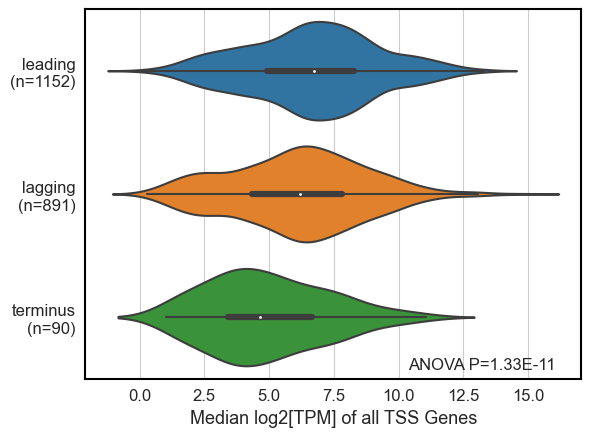

In [60]:
tss_with_log_tpm_df = tss_recon_df[tss_recon_df['median_of_log_tpm_medians'].notna()]

loc_groups = []
for loc, gloc_df in tss_with_log_tpm_df.groupby('replication_region'):
    loc_groups.append(list(gloc_df['median_of_log_tpm_medians']))
    
f, p = f_oneway(*loc_groups)

sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.violinplot(y='replication_region', x='median_of_log_tpm_medians', data=tss_with_log_tpm_df, orient='h', ax=ax)

ax.set_xlabel('Median log2[TPM] of all TSS Genes', fontsize=13)
ax.set_ylabel('')

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
    
ax.set_yticklabels([f"{lab.get_text()}\n(n={tss_with_log_tpm_df[tss_with_log_tpm_df['replication_region'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_yticklabels()])
ax.tick_params(axis='both', labelsize=12)
ax.text(0.65, 0.025, f'ANOVA P={p:.2E}', transform=ax.transAxes, fontsize=12)
    
plt.savefig('/Users/cam/Downloads/tss_rep_region.png', dpi=400, bbox_inches='tight')

## TSS Base

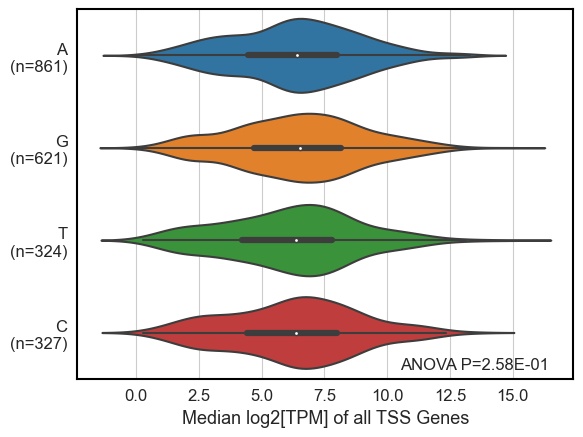

In [61]:
loc_groups = []
for loc, gloc_df in tss_with_log_tpm_df.groupby('tss_base'):
    loc_groups.append(list(gloc_df['median_of_log_tpm_medians']))
    
f, p = f_oneway(*loc_groups)

sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.violinplot(y='tss_base', x='median_of_log_tpm_medians', data=tss_with_log_tpm_df, orient='h', ax=ax)

ax.set_xlabel('Median log2[TPM] of all TSS Genes', fontsize=13)
ax.set_ylabel('')

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
    
ax.set_yticklabels([f"{lab.get_text()}\n(n={tss_with_log_tpm_df[tss_with_log_tpm_df['tss_base'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_yticklabels()])
ax.tick_params(axis='both', labelsize=12)
ax.text(0.65, 0.025, f'ANOVA P={p:.2E}', transform=ax.transAxes, fontsize=12)
    
plt.savefig('/Users/cam/Downloads/tss_base.png', dpi=400, bbox_inches='tight')

## Melting Temperature of Bubble

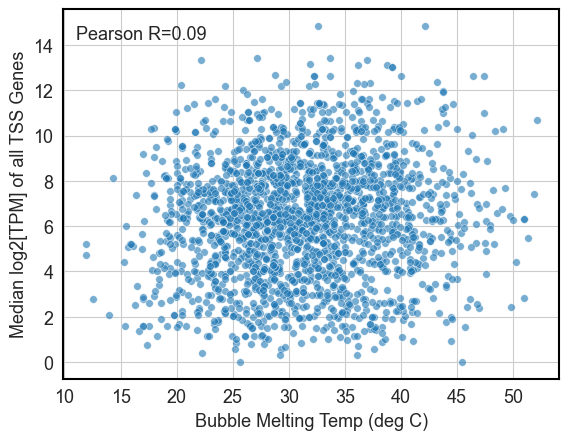

In [62]:
_, ax = plt.subplots()
sns.scatterplot(x='tss_tm', y='median_of_log_tpm_medians', data=tss_with_log_tpm_df, ax=ax, s=30, alpha=0.6)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Bubble Melting Temp (deg C)", fontsize=13)
ax.set_ylabel('Median log2[TPM] of all TSS Genes', fontsize=13)

r, p = pearsonr(tss_with_log_tpm_df['tss_tm'], tss_with_log_tpm_df['median_of_log_tpm_medians'])

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
    
ax.text(0.025, 0.92, f'Pearson R={r:.2f}', transform=ax.transAxes, fontsize=13)

plt.savefig('/Users/cam/Downloads/melting.png', dpi=400, bbox_inches='tight')

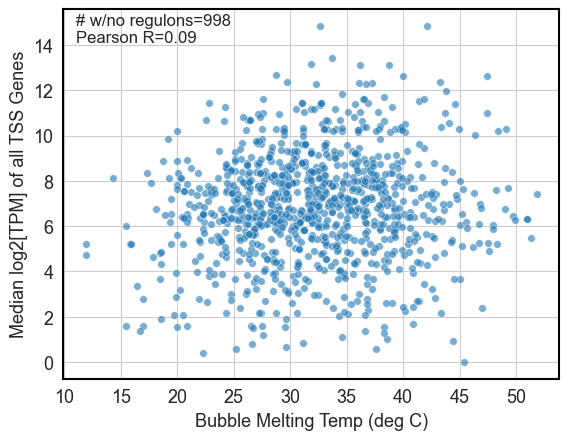

In [63]:
no_regulons = tss_with_log_tpm_df[tss_with_log_tpm_df['regulons'].isna()]

_, ax = plt.subplots()
sns.scatterplot(x='tss_tm', y='median_of_log_tpm_medians', data=no_regulons, ax=ax, s=30, alpha=0.6)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Bubble Melting Temp (deg C)", fontsize=13)
ax.set_ylabel('Median log2[TPM] of all TSS Genes', fontsize=13)

r, p = pearsonr(no_regulons['tss_tm'], no_regulons['median_of_log_tpm_medians'])

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
    
ax.text(0.025, 0.91, f'# w/no regulons={no_regulons.shape[0]}\nPearson R={r:.2f}', transform=ax.transAxes, fontsize=12)

plt.savefig('/Users/cam/Downloads/melting_no_reg.png', dpi=400, bbox_inches='tight')

## -10 Box Score

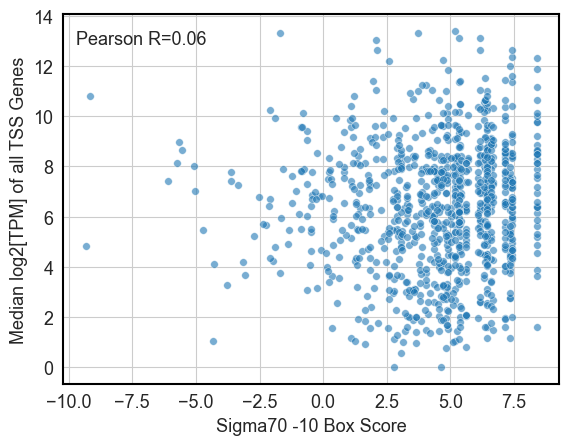

In [64]:
tss_with_sig_df = tss_with_log_tpm_df[tss_with_log_tpm_df['sigma_factor'].notna()]

for sigma_factor in all_sigma_motifs.keys():
    
    sig_factor_df = tss_with_sig_df[tss_with_sig_df['sigma_factor'].str.contains(sigma_factor)]
    sig_factor_m10_df = sig_factor_df[sig_factor_df[f'{sigma_factor}_box_10_score'].notna()]
    
    _, ax = plt.subplots()
    sns.scatterplot(x=f'{sigma_factor}_box_10_score', y='median_of_log_tpm_medians', data=sig_factor_m10_df, ax=ax, s=30, alpha=0.6)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel(f"{sigma_factor} -10 Box Score", fontsize=13)
    ax.set_ylabel('Median log2[TPM] of all TSS Genes', fontsize=13)

    r, p = pearsonr(sig_factor_m10_df[f'{sigma_factor}_box_10_score'], sig_factor_m10_df['median_of_log_tpm_medians'])

    for s in ax.spines.values():
        s.set_color('k')
        s.set_linewidth(1.5)

    ax.text(0.025, 0.92, f'Pearson R={r:.2f}', transform=ax.transAxes, fontsize=13)

    plt.savefig(f'/Users/cam/Downloads/sig_factor_{sigma_factor}_m10.png', dpi=400, bbox_inches='tight')
    break

## Transcriptional Interference

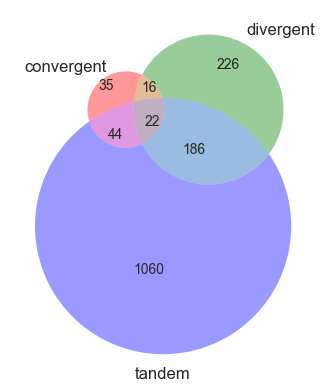

In [65]:
convergent_set = set(tss_recon_df[tss_recon_df['has_convergence']].index)
divergent_set = set(tss_recon_df[tss_recon_df['has_diverging']].index)
tandem_set = set(tss_recon_df[tss_recon_df['has_tandem']].index)

_, ax = plt.subplots()
venn3([convergent_set, divergent_set, tandem_set], set_labels=('convergent', 'divergent', 'tandem'), ax=ax)

plt.savefig(f'/Users/cam/Downloads/interfere_venn.png', dpi=400, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


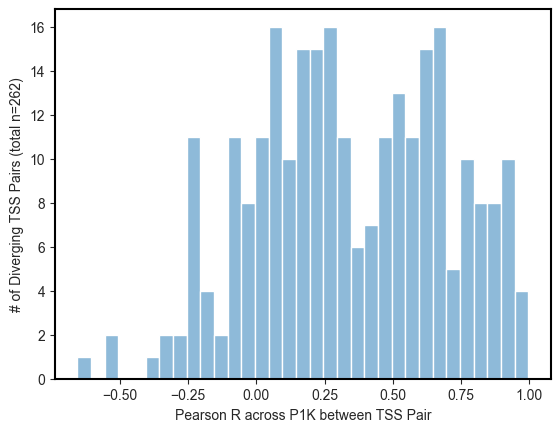

In [66]:
pair_to_pearson = {}

for div_tss1, div_tss2 in diverging_tss_pairs:
    
    if div_tss1 in tss_with_log_tpm_df.index and div_tss2 in tss_with_log_tpm_df.index:
        
        tss1_genes = tss_with_log_tpm_df.loc[div_tss1]['genes_with_log_tpm'].split(';')
        tss2_genes = tss_with_log_tpm_df.loc[div_tss2]['genes_with_log_tpm'].split(';')
        
        tss1_log_tpm_p1k = p1k_log_tpm.loc[tss1_genes].mean(axis=0)
        tss2_log_tpm_p1k = p1k_log_tpm.loc[tss2_genes].mean(axis=0)
        
        r, p = pearsonr(tss1_log_tpm_p1k, tss2_log_tpm_p1k)
        pair_to_pearson[(div_tss1, div_tss2)] = r
        
        
sns.set_style("ticks")
        
_, ax = plt.subplots()

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
        
sns.histplot(pair_to_pearson.values(), ax=ax, binwidth=0.05)
ax.legend().set_visible(False)
ax.set_ylabel(f'# of Diverging TSS Pairs (total n={len(pair_to_pearson)})')
ax.set_xlabel('Pearson R across P1K between TSS Pair')

plt.savefig(f'/Users/cam/Downloads/diverging.png', dpi=400, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


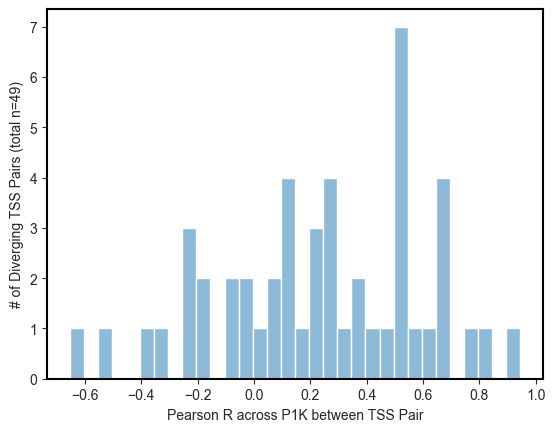

In [67]:
pair_to_pearson_no_reg = {}

for div_tss1, div_tss2 in diverging_tss_pairs:
    
    if div_tss1 in tss_with_log_tpm_df.index and div_tss2 in tss_with_log_tpm_df.index:
        
        if pd.isna(tss_with_log_tpm_df.loc[div_tss1]['regulons']) and pd.isna(tss_with_log_tpm_df.loc[div_tss2]['regulons']):
        
            tss1_genes = tss_with_log_tpm_df.loc[div_tss1]['genes_with_log_tpm'].split(';')
            tss2_genes = tss_with_log_tpm_df.loc[div_tss2]['genes_with_log_tpm'].split(';')

            tss1_log_tpm_p1k = p1k_log_tpm.loc[tss1_genes].mean(axis=0)
            tss2_log_tpm_p1k = p1k_log_tpm.loc[tss2_genes].mean(axis=0)

            r, p = pearsonr(tss1_log_tpm_p1k, tss2_log_tpm_p1k)
            pair_to_pearson_no_reg[(div_tss1, div_tss2)] = r
        
        
sns.set_style("ticks")
        
_, ax = plt.subplots()

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)
        
sns.histplot(pair_to_pearson_no_reg.values(), ax=ax, binwidth=0.05)
ax.legend().set_visible(False)
ax.set_ylabel(f'# of Diverging TSS Pairs (total n={len(pair_to_pearson_no_reg)})')
ax.set_xlabel('Pearson R across P1K between TSS Pair')

plt.savefig(f'/Users/cam/Downloads/diverging_no_reg.png', dpi=400, bbox_inches='tight')

# iM Examples

## Growth Rate Correlations

Text(0, 0.5, '# of iMs (n=201)')

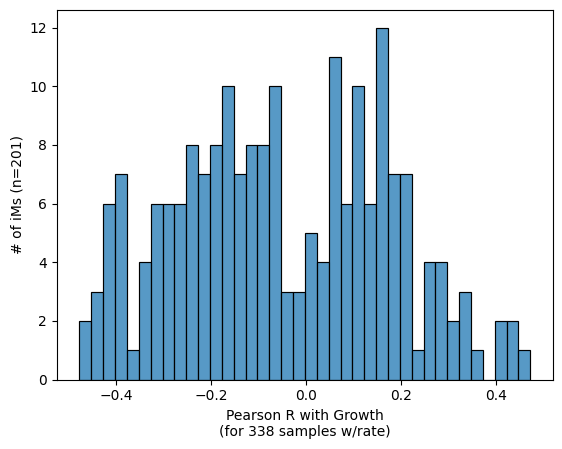

In [676]:
with_growth_rate = p1k.sample_table[(p1k.sample_table['Growth Rate (1/hr)'].notna())]
with_growth_rate = with_growth_rate[with_growth_rate['Growth Rate (1/hr)'] > 0]

growth_rates = with_growth_rate['Growth Rate (1/hr)']

A_with_growth = p1k.A[with_growth_rate.index]

im_to_growth_corr = {im: pearsonr(growth_rates, A_with_growth.loc[im])[0] for im in A_with_growth.index}

im_growth_corr = pd.Series(im_to_growth_corr)

_, ax = plt.subplots()

sns.histplot(im_growth_corr, binwidth=0.025)
ax.set_xlabel('Pearson R with Growth\n(for 338 samples w/rate)')
ax.set_ylabel('# of iMs (n=201)')

In [677]:
pd.DataFrame(im_growth_corr.sort_values().iloc[:10]).round(decimals=2)

,0
PAL 10 Del,-0.48
Acetate,-0.47
Nitrogen,-0.44
ArcA,-0.44
RpoS,-0.43
Putrescine,-0.42
Propionate,-0.42
Phage Shock,-0.41
UC-4,-0.41
NrdR,-0.41


Text(0, 0.5, 'Mean Core RNAP log2[TPM]')

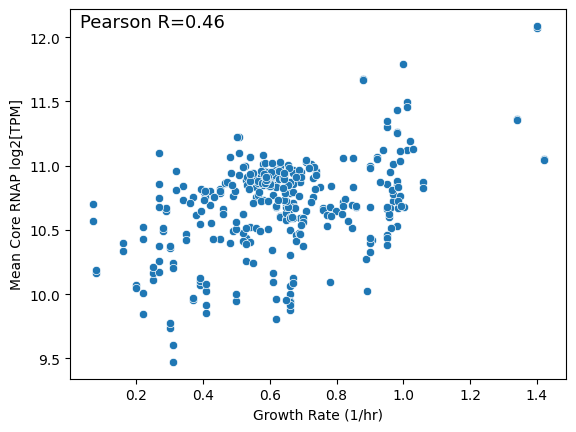

In [683]:
rpo_genes = ['b3295', 'b3987', 'b3988']

rpo_gene_exp = p1k_log_tpm[with_growth_rate.index].loc[rpo_genes].mean()
r, p = pearsonr(growth_rates, rpo_gene_exp)

_, ax = plt.subplots()
sns.scatterplot(x=growth_rates, y=rpo_gene_exp, ax=ax)

ax.text(0.02, 0.95, f'Pearson R={r:.2f}', transform=ax.transAxes, fontsize=13)

ax.set_xlabel('Growth Rate (1/hr)')
ax.set_ylabel('Mean Core RNAP log2[TPM]')

/Users/cam/.venv/bitome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0, 0.5, '# of Genes (n=4355)')

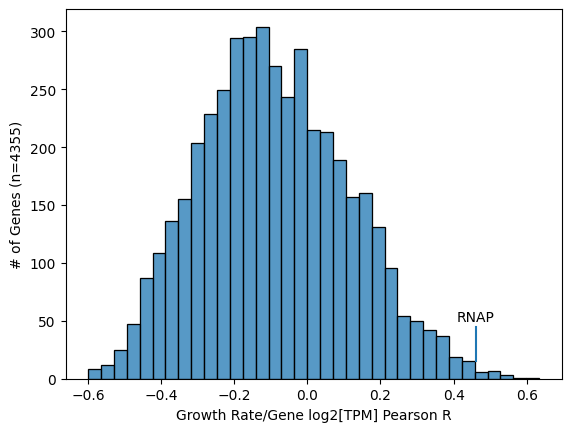

In [692]:
gene_gr_corrs = pd.Series({
    gene_id: pearsonr(growth_rates, p1k_log_tpm.loc[gene_id, with_growth_rate.index])[0] for gene_id in p1k_log_tpm.index
})

_, ax = plt.subplots()

ax.text(0.46, 50, 'RNAP', ha='center')
ax.plot([0.46, 0.46], [15, 45])

sns.histplot(gene_gr_corrs)
ax.set_xlabel('Growth Rate/Gene log2[TPM] Pearson R')
ax.set_ylabel('# of Genes (n=4355)')

In [698]:
p1k_gene_table.loc[gene_gr_corrs.sort_values(ascending=False).iloc[:10].index]

,gene_name,synonyms,gene_product,COG,regulator,uniprot,left,right,strand,essential,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
b2780,pyrG,pyrG,CTP synthetase,Nucleotide transport and metabolism,"YidZ,ppGpp",P0A7E5,2908029,2909666,-,True,...,8.753481,10.699950,6.453029,8.970319,-0.987778,4.246921,1.649069,-2.597852,False,True
b0170,tsf,tsf,protein chain elongation factor EF-Ts,"Translation, ribosomal structure and biogenesis","RpoD,RpsB,ppGpp",P0A6P1,190857,191708,+,True,...,10.059632,11.817057,6.688382,10.302445,-1.513900,5.128674,1.458383,-3.670291,False,False
b4328,iadA,iadA;yjiF,isoaspartyl dipeptidase,Amino acid transport and metabolism,NaN,P39377,4558354,4559526,-,False,...,NaN,7.499732,2.685303,5.466883,-0.827225,4.814429,1.853864,-2.960565,False,False
b3294,rplQ,rplQ,50S ribosomal subunit protein L17,"Translation, ribosomal structure and biogenesis","RpoD,ppGpp,RpsD,DksA",P0AG44,3439616,3439999,-,True,...,11.114969,13.266058,7.993332,11.456586,-1.141543,5.272725,1.568197,-3.704529,False,True
b3313,rplP,rplP,50S ribosomal subunit protein L16,"Translation, ribosomal structure and biogenesis","RpoD,Fnr,ArcA,RplD,DksA",P0ADY7,3448759,3449169,-,True,...,11.205515,13.654659,7.594442,11.557977,-1.020561,6.060217,1.953892,-4.106325,False,True
b3301,rplO,rplO,50S ribosomal subunit protein L15,"Translation, ribosomal structure and biogenesis","ppGpp,RpsH,DksA",P02413,3444105,3444539,-,True,...,11.838445,14.014855,9.299823,12.194394,-0.571182,4.715032,1.708452,-3.006580,False,True
b3295,rpoA,rpoA;pez;phs;sez,RNA polymerase subunit alpha,Transcription,"RpoD,ppGpp,DksA",P0A7Z4,3440040,3441029,-,True,...,11.867208,13.796504,8.531102,12.162081,-1.318367,5.265402,1.547099,-3.718303,False,True
b3296,rpsD,rpsD;ramA,30S ribosomal subunit protein S4,"Translation, ribosomal structure and biogenesis","RpoD,ppGpp,RpsD,DksA",P0A7V8,3441055,3441675,-,True,...,12.097345,13.840352,8.450196,12.325868,-2.130953,5.390156,1.436465,-3.953691,False,True
b3985,rplJ,rplJ,50S ribosomal subunit protein L10,"Translation, ribosomal structure and biogenesis","ppGpp,RplA,DksA",P0A7J3,4179996,4180493,+,True,...,12.136109,13.883692,9.306524,12.437071,-1.080966,4.577168,1.397270,-3.179898,False,True
b1780,yeaD,yeaD;yzzQ,putative aldose 1-epimerase YeaD,Carbohydrate transport and metabolism,"RpoH,Cra",P39173,1863850,1864734,+,False,...,5.935576,8.978116,2.628789,6.567019,-0.479197,6.349327,2.327317,-4.022010,False,True


## ArgR

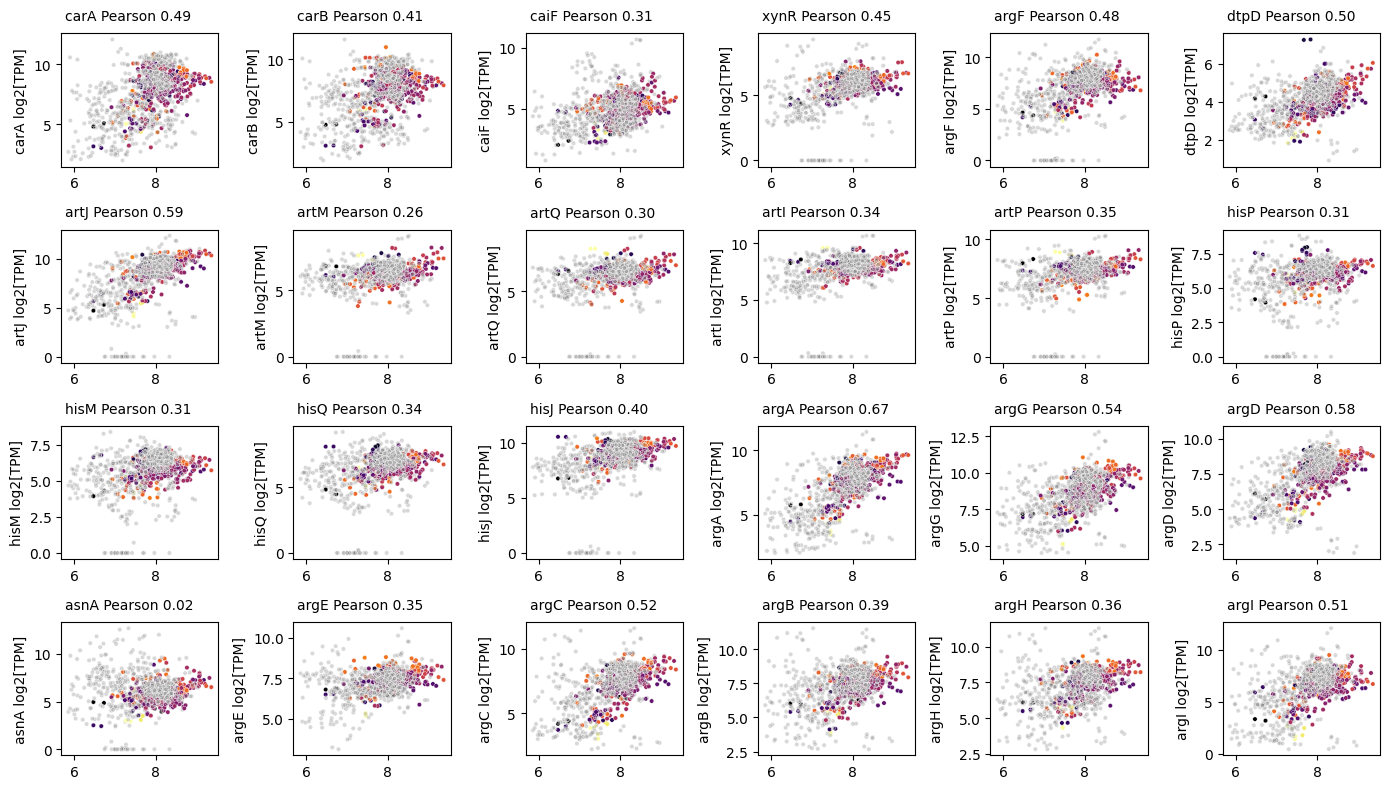

In [269]:
growth_rates = p1k.sample_table['Growth Rate (1/hr)'].value_counts().index
# exclude 0; probably wrong
growth_rates = growth_rates[1:]
rate_min, rate_max = min(growth_rates), max(growth_rates)
def gr_to_unit(gr):
    return (gr - rate_min) / (rate_max - rate_min)

gr_to_color = {gr: plt.get_cmap('inferno')(gr_to_unit(gr)) for gr in growth_rates}

def col_for_samp(samp_id):
    gr = p1k.sample_table.loc[samp_id]['Growth Rate (1/hr)']
    if pd.notna(gr) and gr > 0:
        return gr_to_color[gr]
    else:
        return (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 0.3)

colors = [col_for_samp(samp_id) for samp_id in p1k_log_tpm.columns]

argr_genes = p1k.view_imodulon('Arginine').index

argr_expression = p1k_log_tpm.loc['b3237']

_, axs = plt.subplots(4, 6, figsize=(14, 8))

for argr_gene, ax in zip(argr_genes, axs.flatten()):
    
    gene_exp = p1k_log_tpm.loc[argr_gene]
    r, p = pearsonr(argr_expression, gene_exp)
    gene_name = p1k_gene_table.loc[argr_gene]['gene_name']
    
    sns.scatterplot(x=argr_expression, y=p1k_log_tpm.loc[argr_gene], c=colors, ax=ax, s=10)
    ax.set_xlabel('')
    ax.set_ylabel(f"{gene_name} log2[TPM]")
    ax.text(0.025, 1.1, f'{gene_name} Pearson {r:.2f}', transform=ax.transAxes)
    
plt.tight_layout()

## Gene iM Membership per TSS

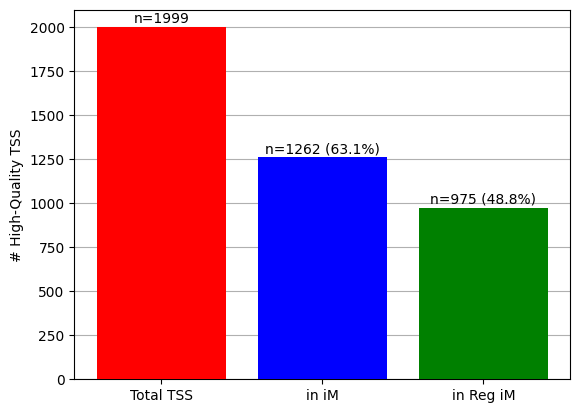

In [270]:
_, ax = plt.subplots()

n_total_tss = tss_recon_df.shape[0]
n_in_im = tss_recon_df[tss_recon_df['imodulons'].notna()].shape[0]
n_in_reg_im = tss_recon_df[tss_recon_df['regulatory_imodulons'].notna()].shape[0]

ax.bar(0, n_total_tss, color='red', zorder=10)
ax.bar(1, n_in_im, color='blue', zorder=10)
ax.bar(2, n_in_reg_im, color='green', zorder=10)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Total TSS', 'in iM', 'in Reg iM'])
ax.set_ylabel('# High-Quality TSS')
ax.set_ylim(0, 2100)

ax.text(0, n_total_tss + 25, f'n={n_total_tss}', ha='center')
ax.text(1, n_in_im + 25, f'n={n_in_im} ({n_in_im/n_total_tss*100:.1f}%)', ha='center')
ax.text(2, n_in_reg_im + 28, f'n={n_in_reg_im} ({n_in_reg_im/n_total_tss*100:.1f}%)', ha='center')

ax.grid(axis='y', zorder=-10)

In [674]:
(tss_in_im_multi_gene['frac_genes_in_im'] == 1).sum()

377

Text(0, 0.5, '# of TSS')

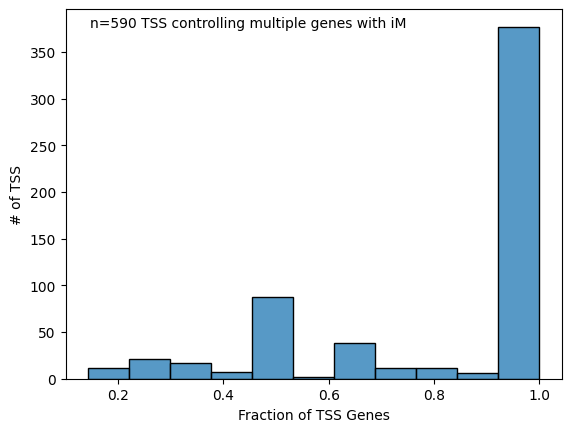

In [670]:
tss_in_im_multi_gene = tss_recon_df[(tss_recon_df['imodulons'].notna()) & (tss_recon_df['n_genes'] > 1)]

_, ax = plt.subplots()

sns.histplot(tss_in_im_multi_gene['frac_genes_in_im'], ax=ax, label='in iM')

ax.text(0.05, 0.95, f'n={tss_in_im_multi_gene.shape[0]} TSS controlling multiple genes with iM', transform=ax.transAxes)

ax.set_xlabel('Fraction of TSS Genes')
ax.set_ylabel('# of TSS')

## dnaKJ/RpoH

Text(0, 0.5, 'log2[TPM]')

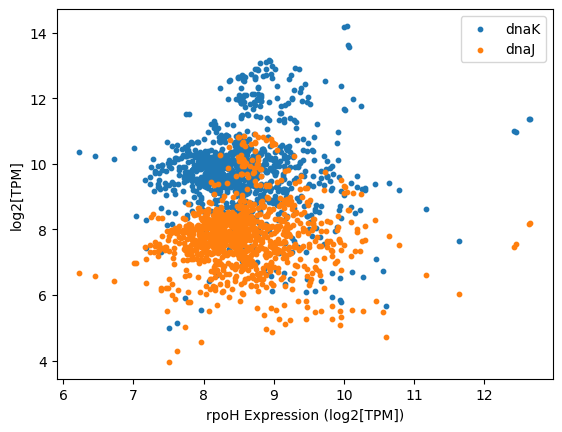

In [272]:
_, ax = plt.subplots()

ax.scatter(p1k_log_tpm.loc['b3461'], p1k_log_tpm.loc['b0014'], s=10, label='dnaK')
ax.scatter(p1k_log_tpm.loc['b3461'], p1k_log_tpm.loc['b0015'], s=10, label='dnaJ')

ax.legend()

ax.set_xlabel('rpoH Expression (log2[TPM])')
ax.set_ylabel('log2[TPM]')

Text(0, 0.5, 'log2[TPM]')

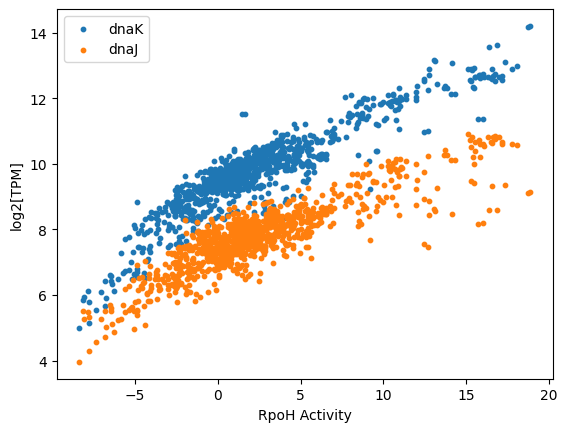

In [273]:
_, ax = plt.subplots()

ax.scatter(p1k.A.loc['RpoH'], p1k_log_tpm.loc['b0014'], s=10, label='dnaK')
ax.scatter(p1k.A.loc['RpoH'], p1k_log_tpm.loc['b0015'], s=10, label='dnaJ')

ax.legend()

ax.set_xlabel('RpoH Activity')
ax.set_ylabel('log2[TPM]')

# Expression NN Models

## Create Datasets

We have a few different pieces for datasets that we can join together

- All genes (sequence input starts from gene start)
- All genes (sequence input starts from 5' UTR of TU)
- Genes with TSS
    - sequence input centered on each TSS
    - ...centered on average of all TSSes
- Each TSS/promoter
    - Ex
    
Start by simply determining a start point and a strand - from there we can take an up/down window of varying size for sweeping

In [312]:
def strand_to_int(strand):
    if strand in ['+', 1.0, 1]:
        return 1
    elif strand in ['-', -1.0, 1]:
        return -1
    else:
        raise ValueError(f'Unrecognized strand {strand}')

### Gene-Centric

#### Targets

Expression levels by gene (median, mean, MAD, all P1K)

In [279]:
gene_target_dict = {
    'median': p1k_gene_table['median_log_tpm'],
    'mean': p1k_gene_table['mean_log_tpm'],
    'MAD': p1k_gene_table['mad_log_tpm'],
    'all_p1k': p1k_log_tpm
}

#### from Gene Start

Don't necessarily expect this to be super good as many genes are in transcription units

In [447]:
all_gene_from_gene_start_df = p1k_gene_table[['left', 'right', 'strand']]
all_gene_from_gene_start_df = all_gene_from_gene_start_df.assign(
    start=all_gene_from_gene_start_df.apply(lambda row: row['left'] if row['strand'] == '+' else row['right'], axis=1)
)
all_gene_from_gene_start_df = all_gene_from_gene_start_df.drop(columns=['left', 'right'])
all_gene_from_gene_start_df = all_gene_from_gene_start_df.assign(
    strand=all_gene_from_gene_start_df['strand'].apply(strand_to_int)
)

#### from TU/Gene Start

- If gene is in a TU:
    - If TU has TSS:
        - Use that
    - Else if TU has no TSS:
        - Use TU start
    - If in multiple TUs, use each
- Use gene start

In [418]:
tss_with_gene_ids = tss_recon_df[(tss_recon_df['gene_ids'].notna())]

all_gene_from_tu_start_rows = []
all_gene_from_tss_group_rows = []

for p1k_gene_id, p1k_gene_row in p1k_gene_table.iterrows():
    
    tss_for_gene_df = tss_with_gene_ids[tss_with_gene_ids['gene_ids'].str.contains(p1k_gene_id)]
    tu_without_tss_for_gene_df = mg1655.tu_table.loc[mg1655._gene_to_tus[p1k_gene_id]]
    tu_without_tss_for_gene_df = tu_without_tss_for_gene_df[tu_without_tss_for_gene_df['tss'].isna()]
    
    if not tss_for_gene_df.empty:

        tss_seen_already = []
        for tss_id, tss_row in tss_for_gene_df.iterrows():

            basic_tss_row_dict = {
                'gene_id': p1k_gene_id,
                'tss_id': tss_id,
                'start': tss_row['tss'],
                'strand': p1k_gene_row['strand']
            }
            all_gene_from_tu_start_rows.append(basic_tss_row_dict)
            
            if pd.notna(tss_row['alternate_tss_ids']) and tss_id not in tss_seen_already:
                alt_tss_ids = tss_row['alternate_tss_ids'].split(';')
                all_alt_tss_ids = [tss_id] + alt_tss_ids
                mean_tss_loc = round(np.mean(tss_with_gene_ids.loc[all_alt_tss_ids]['tss']))
                all_gene_from_tss_group_rows.append({
                    'gene_id': p1k_gene_id,
                    'tss_id': ';'.join(all_alt_tss_ids),
                    'start': mean_tss_loc,
                    'strand': p1k_gene_row['strand']
                })
                tss_seen_already.extend(all_alt_tss_ids)
            elif tss_id not in tss_seen_already:
                all_gene_from_tss_group_rows.append(basic_tss_row_dict)

    elif not tu_without_tss_for_gene_df.empty:
        
        for tu_id, tu_row in tu_without_tss_for_gene_df.iterrows():
            tu_row_dict = {
                'gene_id': p1k_gene_id,
                'tu_id': tu_id,
                'start': tu_row['left'] if tu_row['strand'] == 1 else tu_row['right'],
                'strand': tu_row['strand']
            }
            all_gene_from_tu_start_rows.append(tu_row_dict)
            all_gene_from_tss_group_rows.append(tu_row_dict)
        
    else:
        
        gene_row_dict = {
            'gene_id': p1k_gene_id,
            'start': p1k_gene_row['left'] if p1k_gene_row['strand'] == '+' else p1k_gene_row['right'],
            'strand': p1k_gene_row['strand']
        }
        all_gene_from_tu_start_rows.append(gene_row_dict)
        all_gene_from_tss_group_rows.append(gene_row_dict)
        
all_gene_from_tu_start_df = pd.DataFrame(all_gene_from_tu_start_rows)
all_gene_from_tu_start_df = all_gene_from_tu_start_df.assign(
    strand=all_gene_from_tu_start_df['strand'].apply(strand_to_int)
)

all_gene_from_tss_group_df = pd.DataFrame(all_gene_from_tss_group_rows)
all_gene_from_tss_group_df = all_gene_from_tss_group_df.assign(
    strand=all_gene_from_tss_group_df['strand'].apply(strand_to_int)
)

### TSS-centric

In [429]:
tss_with_log_tpm = tss_recon_df[tss_recon_df['genes_with_log_tpm'].notna()]

#### Targets

In [430]:
tss_target_dict = {
    'median_of_medians': tss_with_log_tpm['median_of_log_tpm_medians'],
    'all_p1k_mean_genes': tss_with_log_tpm['genes_with_log_tpm'].str.split(';').apply(lambda gids: p1k_log_tpm.loc[gids].mean())
}

#### all TSSes

In [564]:
all_tss_df = tss_with_log_tpm[['tss', 'strand']]
all_tss_df = all_tss_df.rename(columns={'tss': 'start'})

#### TSS Groups

In [439]:
tss_group_rows = []

tss_seen_already = []
for tss_id, tss_row in tss_with_log_tpm.iterrows():

    if pd.notna(tss_row['alternate_tss_ids']) and tss_id not in tss_seen_already:
        alt_tss_ids = tss_row['alternate_tss_ids'].split(';')
        all_alt_tss_ids = [tss_id] + alt_tss_ids
        mean_tss_loc = round(np.mean(tss_with_log_tpm.loc[all_alt_tss_ids]['tss']))
        tss_group_rows.append({
            'tss_id': ';'.join(all_alt_tss_ids),
            'start': mean_tss_loc,
            'strand': tss_row['strand']
        })
        tss_seen_already.extend(all_alt_tss_ids)
    elif tss_id not in tss_seen_already:
        tss_group_rows.append({
            'tss_id': tss_id,
            'start': tss_row['tss'],
            'strand': tss_row['strand']
        })
        
all_tss_group_df = pd.DataFrame(tss_group_rows)

## pyTorch Helper Functions

### one_hot_encode

In [444]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """ 
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

### Dataset

In [484]:
## Here is a custom defined Dataset object specialized for one-hot encoded DNA:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 seq_df,
                 Y_df):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(seq_df['seq'].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(Y_df.values))
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self, idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

### Models

#### DNALinear

In [485]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len, out_shape):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, out_shape)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

#### DNA_CNN

In [656]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 out_shape,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len

        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), out_shape)
        )

    def forward(self, xb):
        # permute to put channel in correct order
        # (batch_size x 4channel x seq_len)
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out

#### DNA_Transformer

### Train/Val Step Functions

In [657]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None, verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float())
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to('cpu'), yb.to('cpu')
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to('cpu'),yb.to('cpu')

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:  
                self.early_stop = True

### ModelDatasetExperiment

A very high-level class that will allow for running a set of trials for a particular Xy pairing

In [658]:
class ModelDatasetExperiment:
    
    def __init__(self,
                 model,
                 X_df,
                 Y_df,
                 up_down,
                 name,
                 model_param_dict=None,
                 optimizer='Adam',
                 loss_function='MAE',
                 patience=3,
                 lr=0.001,
                 val_frac=0.05,
                 test_frac=0.01,
                 batch_size=32,
                 max_epochs=50,
                 bitome=mg1655,
                 random_state=42):
        """
        model: name of a model to generate
        X_df: a DF of samples - should have a unique index - should contain 'start' and 'strand' columns at minimum
        y_df: a DF of labels - should have same index as X_df - should be DF EVEN if only 1 column
        up_down: upstream/downstream sequence range, as a tuple
        name: a name for this dataset
        model_param_dict: optional dictionary of parameters to pass to the model
        optimizer: the optimizer to use (defaults to Adam)
        loss_function: the loss function to use
        patience: the number of epochs with no validation reduction after which to early stop
        lr: the learning rate for the given optimizer
        val_frac: fraction OF THE TRAINING SET to use as validation samples
        test_frac: fraction of input dataset to set aside for unseen testing
        batch_size: to be used when training model
        max_epochs: the maximum number of epochs to train a given fold (may be less with early stopping, etc.)
        bitome: a Bitome object for which the sequences have meaning
        """
        assert model in ['Linear', 'CNN', 'Transformer']
        assert isinstance(X_df, pd.DataFrame) and isinstance(Y_df, pd.DataFrame)
        assert len(X_df.index) == len(set(X_df.index))
        assert len(Y_df.index) == len(set(Y_df.index))
        assert all(X_df.index == Y_df.index)
        assert isinstance(up_down, tuple) and len(up_down) == 2
        assert isinstance(up_down[0], int) and isinstance(up_down[1], int)
        assert isinstance(name, str)
        assert isinstance(model_param_dict, dict) or model_param_dict is None
        assert optimizer in ['Adam']
        assert loss_function in ['MAE']
        assert isinstance(patience, int) and patience >= 0
        assert isinstance(lr, float)
        assert isinstance(val_frac, float) and 0 < val_frac < 1
        assert isinstance(test_frac, float) and 0 < test_frac < 1
        assert isinstance(batch_size, int) and batch_size > 0
        assert isinstance(max_epochs, int) and max_epochs > 0
        assert isinstance(bitome, Bitome)
        assert isinstance(random_state, int)
        
        self.model_name = model
        self.X = X_df
        self.Y = Y_df
        self.out_shape = Y_df.shape[1]
        # asserted as same as Y
        self.index = X_df.index
        self.n_upstream = up_down[0]
        self.n_downstream = up_down[1]
        self.seq_len = sum(up_down) + 1
        self.model_param_dict = dict() if model_param_dict is None else model_param_dict
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.patience = patience
        self.lr = lr
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.n_test_splits = int(1 / test_frac)
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.bitome = bitome
        self.random_state = random_state
        
        self.X_seq = self.get_sequence(*up_down)
        
    def run_cv(self):
        """
        Run through model training for all the requested folds (implied by test fraction)
        """
        train_val_test_idxes = self.get_train_val_test_splits()
        
        for train_idx, val_idx, test_idx in train_val_test_idxes:
            train_losses, val_losses = self.run_fold(train_idx, val_idx, test_idx)
            
    def run_single_fold(self):
        """
        Generate a single train/val/test split and just run a model on that
        """
        train_val_test_idxes = self.get_train_val_test_splits()
        train_losses, val_losses = self.run_fold(*train_val_test_idxes[0])
        return train_losses, val_losses
        
    def run_fold(self, train_idx, val_idx, test_idx):
        """
        Run a single fold of model training on a particular train/val/test index
        """
        
        train_dl, val_dl = self.build_dataloaders(self.X_seq, train_idx, val_idx)
        
        # copy the base model and put it on the CPU
        model = self.build_model()
        model.to('cpu') # put on CPU - I no have GPU :( 

        # define optimizer and loss
        if self.optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
            
        if self.loss_function == 'MAE':
            loss_func = torch.nn.L1Loss()
            
        # run the training loop! use early stopping
        early_stop = EarlyStopping(patience=self.patience, min_delta=0)
        train_losses = []
        val_losses = []
        for epoch in range(self.max_epochs):

            # take a training step
            train_loss = train_step(model, train_dl, loss_func, optimizer)
            train_losses.append(train_loss)

            # take a validation step
            val_loss = val_step(model, val_dl, loss_func)
            val_losses.append(val_loss)
            
            print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # early stopping
            early_stop(train_loss, val_loss)
            if early_stop.early_stop:
                print(f"Stop at epoch: {epoch}")
                break
                
        # run a prediction on the requested test set
        actuals, preds = self.predict(model, test_idx)

        return actuals, preds
        
    def get_train_val_test_splits(self):
        """
        Return index groups to use as train/val/test indices
        """
        return [
            [
                list(np.array(self.index)[selection])
                for selection in (
                    *train_test_split(trainval_idxes, test_size=self.val_frac, shuffle=True, random_state=self.random_state),
                    test_idxes
                )
            ]
            for trainval_idxes, test_idxes in KFold(n_splits=self.n_test_splits, shuffle=True, random_state=self.random_state).split(self.index)
        ]
        
    def get_sequence(self, up, down):
        """
        Given upstream and downstream dists, return a single-column DF (labeled 'seq')
        containing the appropriate sequence based on the X dataframe and using the 
        bitome associated with this instance
        """
        def get_seq(row):
            if row['strand'] == 1:
                left, right = row['start'] - up, row['start'] + down
            else:
                left, right = row['start'] - down, row['start'] + up
            return str(self.bitome.get_sequence(left, right, row['strand']))
        return pd.DataFrame(self.X.apply(get_seq, axis=1), columns=['seq'], index=self.X.index)
    
    def predict(self, model, test_idx):
        """
        Given a test dataloader, return predictions
        """
        test_seqs = self.X_seq.loc[test_idx]['seq'].tolist()
        actuals = self.Y.loc[test_idx].iloc[:, 0].tolist()
        preds = []
        for test_seq, actual in zip(test_seqs, actuals):
            s = torch.tensor(one_hot_encode(test_seq)).unsqueeze(0).to('cpu')
            pred = model(s.float())
            preds.append(pred.item())
        return actuals, preds
    
    def build_dataloaders(self,
                          seq_df,
                          train_idx,
                          val_idx,
                          batch_size=64,
                          shuffle=True):
        """
        Given a train and test df with some batch construction
        details, put them into custom SeqDatasetOHE() objects. 
        Give the Datasets to the DataLoaders and return.
        """
        
        # extract the relevant datasets based on the given indices
        seq_train_df, seq_val_df = seq_df.loc[train_idx], seq_df.loc[val_idx]
        Y_train_df, Y_val_df = self.Y.loc[train_idx], self.Y.loc[val_idx]

        # Put DataSets into DataLoaders
        train_dl = DataLoader(SeqDatasetOHE(seq_train_df, Y_train_df), batch_size=batch_size, shuffle=shuffle)
        val_dl = DataLoader(SeqDatasetOHE(seq_val_df, Y_val_df), batch_size=batch_size)

        return train_dl, val_dl
    
    def build_model(self):
        if self.model_name == 'Linear':
            return DNA_Linear(self.seq_len, self.out_shape, **self.model_param_dict)
        elif self.model_name == 'CNN':
             return DNA_CNN(self.seq_len, self.out_shape, **self.model_param_dict)
        elif self.model_name == 'Transformer':
             return DNA_Transformer(self.seq_len, self.out_shape, **self.model_param_dict)

## Run Models

In [660]:
mde = ModelDatasetExperiment(
    'CNN',
    all_tss_df,
    pd.DataFrame(tss_target_dict['median_of_medians']),
    (100, 50),
    'test1',
    max_epochs=20,
    model_param_dict={'num_filters': 6, 'kernel_size': 6}
)
mde.run_single_fold()

E0 | train loss: 4.982 | val loss: 2.696
E1 | train loss: 2.182 | val loss: 1.986
E2 | train loss: 2.031 | val loss: 1.976
E3 | train loss: 2.012 | val loss: 1.983
E4 | train loss: 1.998 | val loss: 1.978
E5 | train loss: 1.988 | val loss: 1.972
E6 | train loss: 1.988 | val loss: 1.982
E7 | train loss: 1.975 | val loss: 2.025
E8 | train loss: 1.957 | val loss: 1.980
E9 | train loss: 1.943 | val loss: 1.981
Stop at epoch: 9


([4.450686055445439,
  5.240372119,
  8.913623267805345,
  9.615162229,
  6.8458147085,
  10.29394386,
  1.080747012,
  2.1739256890000003,
  6.3942960525000005,
  2.54740412,
  7.989492703,
  9.605099614,
  3.257845891,
  3.114303052,
  8.141401661,
  7.341249462,
  7.888788796,
  7.071270477944764,
  3.904360722],
 [6.859514236450195,
  7.107345104217529,
  6.4160356521606445,
  6.244894981384277,
  5.937900543212891,
  6.575987339019775,
  6.011114120483398,
  5.455472946166992,
  6.313394069671631,
  6.277023792266846,
  6.287203788757324,
  6.662178993225098,
  5.749682903289795,
  6.57194185256958,
  6.147429466247559,
  6.458963871002197,
  6.431675434112549,
  6.30776309967041,
  6.975429534912109])

# Shape Profiling

Use PCA to reduce dimensionality of shape in certain regions

In [16]:
TSS_UP = 3
TSS_DOWN = 3
tss_region_shape_rows = []

# from CENTER for -10/-35
BOX_10_UP = 3
BOX_10_DOWN = 3
box_10_shape_rows = []

BOX_35_UP = 3
BOX_35_DOWN = 3
box_35_shape_rows = []

# from CENTRAL "position"
SPACER_UP = 5
SPACER_DOWN = 5
spacer_shape_rows = []

box_spacer_index = []

for tss_recon_id, tss_recon_row in tss_recon_df.iterrows():
    
    # define the positions from which to get shape
    strand = tss_recon_row['strand']
    tss_region_shape_row = {}
    if strand == 1:
        tss_region_shape_row['left'] = tss_recon_row['tss'] - TSS_UP
        tss_region_shape_row['right'] = tss_recon_row['tss'] + TSS_DOWN
        tss_region_shape_row['strand'] = strand

    else:
        tss_region_shape_row['left'] = tss_recon_row['tss'] - TSS_DOWN
        tss_region_shape_row['right'] = tss_recon_row['tss'] + TSS_UP
        tss_region_shape_row['strand'] = strand
    tss_region_shape_rows.append(tss_region_shape_row)
        
    b10_l, b10_r = tss_recon_row['box_10_left'], tss_recon_row['box_10_right']
    b35_l, b35_r = tss_recon_row['box_35_left'], tss_recon_row['box_35_right']
    
    # -10/-35 box sequences and motif scores
    if all([pd.notna(b) for b in [b10_l, b10_r, b35_l, b35_r]]):
        
        box_spacer_index.append(tss_recon_id)
        box_10_shape_row = {}
        box_35_shape_row = {}
        spacer_shape_row = {}
        
        b10_center = np.ceil((b10_l + b10_r) / 2)
        b35_center = np.ceil((b35_l + b35_r) / 2)
        
        # round towards TSS
        if strand == 1:
            box_10_shape_row['left'] = b10_center - BOX_10_UP
            box_10_shape_row['right'] = b10_center + BOX_10_DOWN
            box_10_shape_row['strand'] = strand

            box_35_shape_row['left'] = b35_center - BOX_35_UP
            box_35_shape_row['right'] = b35_center + BOX_35_DOWN
            box_35_shape_row['strand'] = strand
            
            spacer_center = np.ceil((b10_l + b35_r) / 2)
            spacer_shape_row['left'] = spacer_center - SPACER_UP
            spacer_shape_row['right'] = spacer_center + SPACER_DOWN
            spacer_shape_row['strand'] = strand
        else:
            box_10_shape_row['left'] = b10_center - BOX_10_DOWN
            box_10_shape_row['right'] = b10_center + BOX_10_UP
            box_10_shape_row['strand'] = strand

            box_35_shape_row['left'] = b35_center - BOX_35_DOWN
            box_35_shape_row['right'] = b35_center + BOX_35_UP
            box_35_shape_row['strand'] = strand
            
            # round towards TSS
            spacer_center = np.floor((b10_r + b35_l) / 2)
            spacer_shape_row['left'] = spacer_center - SPACER_DOWN
            spacer_shape_row['right'] = spacer_center + SPACER_UP
            spacer_shape_row['strand'] = strand
            
        box_10_shape_rows.append(box_10_shape_row)
        box_35_shape_rows.append(box_35_shape_row)
        spacer_shape_rows.append(spacer_shape_row)

tss_region_for_shape_df = pd.DataFrame(tss_region_shape_rows, index=tss_recon_df.index)
box_10_for_shape_df = pd.DataFrame(box_10_shape_rows, index=box_spacer_index).astype(int)
box_35_for_shape_df = pd.DataFrame(box_35_shape_rows, index=box_spacer_index).astype(int)
spacer_for_shape_df = pd.DataFrame(spacer_shape_rows, index=box_spacer_index).astype(int)

# compute shapes for all of these feature tables!
tss_shape_dict = mg1655.get_dna_shape_for_features(tss_region_for_shape_df)
box_10_shape_dict = mg1655.get_dna_shape_for_features(box_10_for_shape_df)
box_35_shape_dict = mg1655.get_dna_shape_for_features(box_35_for_shape_df)
spacer_shape_dict = mg1655.get_dna_shape_for_features(spacer_for_shape_df)

# normalize and flatten the shape listings into DataFrames
tss_shape_flat_df = pd.DataFrame(
    [shape_df.set_index(np.arange(-TSS_UP, TSS_DOWN + 1)).unstack() for shape_df in tss_shape_dict.values()],
    index=tss_shape_dict.keys()
)
tss_shape_z_df = (tss_shape_flat_df - tss_shape_flat_df.mean()) / tss_shape_flat_df.std()
box_10_shape_flat_df = pd.DataFrame(
    [shape_df.set_index(np.arange(-BOX_10_UP, BOX_10_DOWN + 1)).unstack() for shape_df in box_10_shape_dict.values()],
    index=box_10_shape_dict.keys()
)
box_10_shape_z_df = (box_10_shape_flat_df - box_10_shape_flat_df.mean()) / box_10_shape_flat_df.std()
box_35_shape_flat_df = pd.DataFrame(
    [shape_df.set_index(np.arange(-BOX_35_UP, BOX_35_DOWN + 1)).unstack() for shape_df in box_35_shape_dict.values()],
    index=box_35_shape_dict.keys()
)
box_35_shape_z_df = (box_35_shape_flat_df - box_35_shape_flat_df.mean()) / box_35_shape_flat_df.std()
spacer_shape_flat_df = pd.DataFrame(
    [shape_df.set_index(np.arange(-SPACER_UP, SPACER_DOWN + 1)).unstack() for shape_df in spacer_shape_dict.values()],
    index=spacer_shape_dict.keys()
)
spacer_shape_z_df = (spacer_shape_flat_df - spacer_shape_flat_df.mean()) / spacer_shape_flat_df.std()

N_RAND = box_10_shape_z_df.shape[0]

rand_shape_rows = []

for i in range(N_RAND):
    rand_center = np.random.choice(np.arange(1, mg1655.seq_length))
    rand_strand = np.random.choice([1, -1])
    if rand_strand == 1:
        rand_l, rand_r = rand_center - BOX_10_UP, rand_center + BOX_10_DOWN
    else:
        rand_l, rand_r = rand_center - BOX_10_DOWN, rand_center + BOX_10_UP
    rand_shape_rows.append({
        'left': rand_l,
        'right': rand_r,
        'strand': rand_strand
    })
    
rand_shape_df = pd.DataFrame(rand_shape_rows)

rand_shape_dict = mg1655.get_dna_shape_for_features(rand_shape_df)

rand_shape_flat_df = pd.DataFrame(
    [shape_df.set_index(np.arange(-TSS_UP, TSS_DOWN + 1)).unstack() for shape_df in rand_shape_dict.values()],
    index=rand_shape_dict.keys()
)
rand_shape_z_df = (rand_shape_flat_df - rand_shape_flat_df.mean()) / rand_shape_flat_df.std()

labels = ['TSS', '-10 Box', '-35 Box', 'Spacer', 'Random']
shape_df_lookup = {
    'Flat Raw': dict(zip(labels, [tss_shape_flat_df, box_10_shape_flat_df, box_35_shape_flat_df, spacer_shape_flat_df, rand_shape_flat_df])),
    'Flat Z': dict(zip(labels, [tss_shape_z_df, box_10_shape_z_df, box_35_shape_z_df, spacer_shape_z_df, rand_shape_z_df]))
}

## PCA

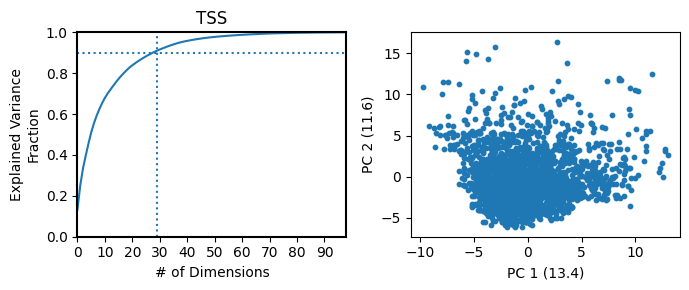

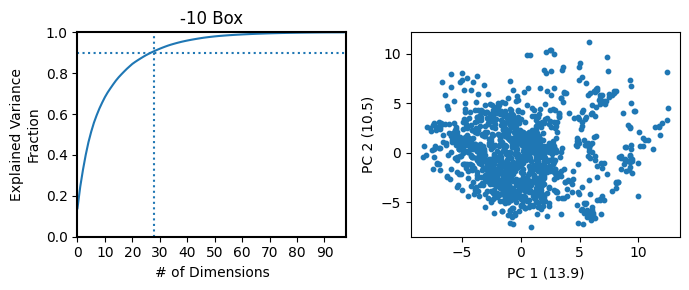

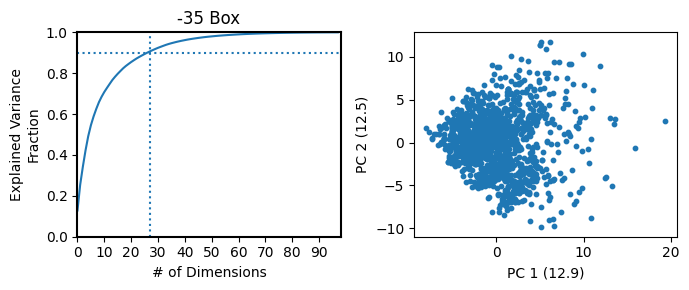

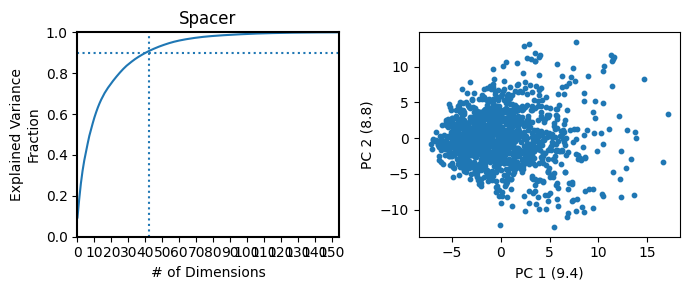

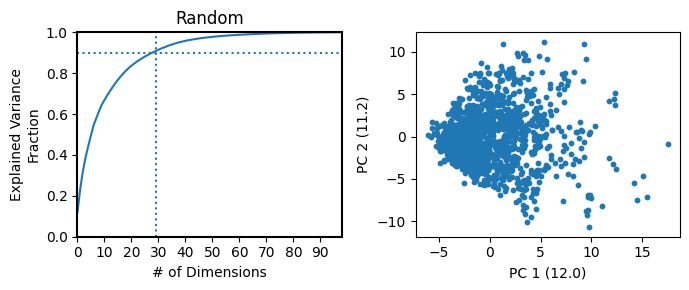

In [17]:
# Set the explained variance threshold; we want to store truncated PCA components
var_cutoff = 0.9

pca_cutoff_dfs = {}
pca_weight_dfs = {}
pca_component_dfs = {}

for lab, flat_z_df in shape_df_lookup['Flat Z'].items():
    
    pca = PCA()
    DF_weights = pd.DataFrame(pca.fit_transform(flat_z_df), index=flat_z_df.index)
    DF_components = pd.DataFrame(pca.components_.T, index=flat_z_df.columns)
    pca_weight_dfs[lab] = DF_weights
    pca_component_dfs[lab] = DF_components
    
    pca_var = np.cumsum(pca.explained_variance_ratio_)
    dims = np.where(pca_var > var_cutoff)[0][0] + 1
    
    pca_cutoff_dfs[lab] = DF_weights.iloc[:, :dims]

    _, (ax, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax.plot(pca_var)
    ax.set_title(f'{lab}')
    ax.vlines(dims,0,1,linestyles='dotted')
    ax.hlines(var_cutoff,0,len(flat_z_df.index),linestyles='dotted')
    ax.set_ylim(0,1)
    ax.set_xlim(0,DF_components.shape[0])
    ax.set_ylabel('Explained Variance\nFraction',fontsize=10)
    ax.set_xlabel('# of Dimensions',fontsize=10)
    ax.set_xticks(np.arange(0, DF_components.shape[0], 10))
    for s in ax.spines.values():
        s.set_color('black')
        s.set_linewidth(1.5)
        
    ax2.scatter(DF_weights[0], DF_weights[1], s=10)
    ax2.set_xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]*100:.1f})')
    ax2.set_ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]*100:.1f})')
    
    plt.tight_layout()
        
shape_df_lookup['PCA Cutoff'] = pca_cutoff_dfs
shape_df_lookup['PCA Weights'] = pca_weight_dfs
shape_df_lookup['PCA Components'] = pca_component_dfs

## Clustering

In [220]:
n_clusters_to_try = np.arange(2, 25)

result_rows = []

types_to_try = ['Flat Z', 'PCA Cutoff']

for i, (shape_df_type, shape_df_dict) in enumerate(shape_df_lookup.items()):
    if shape_df_type in types_to_try:
        
        for j, (feat_name, shape_df) in enumerate(shape_df_dict.items()):

            for k, n_clusters in enumerate(n_clusters_to_try):
                print(f'Shape Type ({i+1}/{len(shape_df_lookup)}) Feat ({j+1}/{len(shape_df_dict)}) n_clusters ({k+1}/{len(n_clusters_to_try)})', end='\r')
                kmeans = KMeans(n_clusters=n_clusters)
                labels = kmeans.fit_predict(shape_df)
                sil_score = silhouette_score(shape_df, labels, metric='euclidean')
                result_rows.append({
                    'shape_df_type': shape_df_type,
                    'feat_name': feat_name,
                    'n_clusters': n_clusters,
                    'silhouette': sil_score
                })

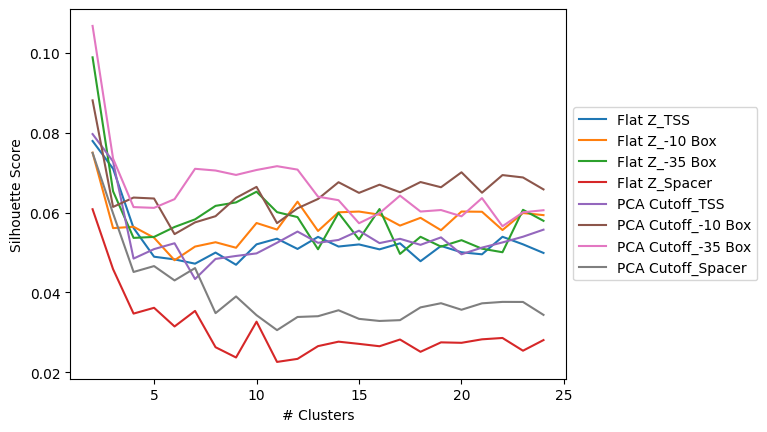

In [226]:
result_df = pd.DataFrame(result_rows)
result_df = result_df.assign(
    type_name=result_df.apply(lambda row: f"{row['shape_df_type']}_{row['feat_name']}", axis=1)
)

_, ax = plt.subplots()

sns.lineplot(x='n_clusters', y='silhouette', hue='type_name', data=result_df, ax=ax)

ax.set_xlabel('# Clusters')
ax.set_ylabel('Silhouette Score')
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')

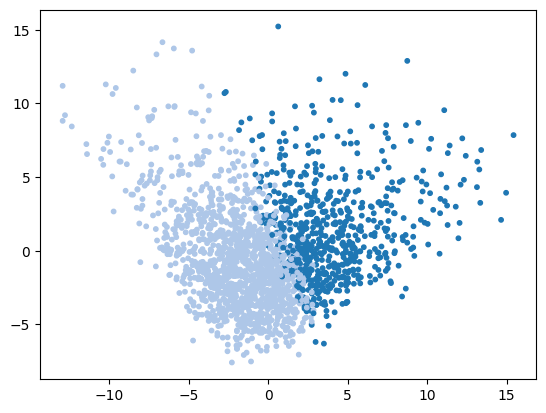

In [278]:
example_labels = KMeans(n_clusters=2).fit_predict(shape_df_lookup['Flat Z']['TSS'])
pca_weights = shape_df_lookup['PCA Weights']['TSS']

color_dict = dict(zip(np.arange(0, len(n_clusters_to_try)), plt.get_cmap('tab20').colors))

_, ax = plt.subplots()

ax.scatter(pca_weights[0], pca_weights[1], s=10, c=[color_dict[lab] for lab in example_labels])